In [1]:
# Define a vector of package names to be used in the script
package_names_vec <- c(
  "tidyverse",
  "ggtext",
  "showtext",
  "readxl",
  "readxl",
  "srvyr",
  "viridis",
  "scales",
  "ggalluvial",
  "ggeffects",
  "emmeans",
  "survey",
  "broom",
  "repr",
  "patchwork"
)

package_prep <- function(names_vec) {
  for (name in names_vec) {
    # if not installed, install it
    if (!requireNamespace(name, quietly = TRUE)) {
      install.packages(name)
    }
    # in any case, load it
    library(name, character.only = TRUE)
  }
}

# Pipe the vector of package names into the package_prep function
package_names_vec |> package_prep()





if (grepl("kaggle", getwd())) {
  paths <- list(
    input = file.path("/kaggle", "input", "cleaned-gfi","output"),
    output = file.path("/kaggle", "working", "output")
  )
} else {
  paths <- list(
    input = file.path("..", "output"),
    output = file.path("..", "figures")
  )
}

if (!dir.exists(paths$input)) {
  stop("INPUT DATA NOT FOUND\n DO NOT RUN THIS CODE.")
}

fig <- function(plot_obj,
                width,
                height,
                dpi    = 96,
                filename = "untitled",
                output_dir = "plots",
                ...) {
    output_dir = paths$output
  # 1) Ensure output directory exists
  if (!dir.exists(output_dir)) {
    dir.create(output_dir, recursive = TRUE)
  }
  
  # 2) Save to disk
  file_path <- file.path(output_dir, paste0(filename, ".png"))
  ggsave(
    filename = file_path,
    plot     = plot_obj,
    width    = width,
    height   = height,
    dpi      = dpi,
    ...
  )
  message("Saved plot to: ", normalizePath(file_path))
  
  # 3) Print & capture the plot
  print(plot_obj)
  rp <- recordPlot()
  
  # 4) Create a PNG at exactly the requested dimensions
  img_data <- repr::repr_png(
    rp,
    width  = width,
    height = height,
    res    = dpi
  )
  
  # 5) Display it inline at full size
  IRdisplay::display_png(img_data)
}


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: sysfonts



Loading required package: showtextdb



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




Attaching package: ‘srvyr’




The following object is masked from ‘package:stats’:

    filter




Loading required package: viridisLite




Attaching package: ‘scales’




The following object is masked from ‘package:viridis’:

    viridis_pal




The following object is masked from ‘package:purrr’:

    discard




The following object is masked from ‘package:readr’:

    col_factor




Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'



Loading required package: grid



Loading required package: Matrix




Attaching package: ‘Matrix’




The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




Loading required package: survival




Attaching package: ‘survey’




The following object is masked from ‘package:graphics’:

    dotchart




In [2]:
gfi_tbl <- paths$input |> file.path("gfi.csv") |> read_csv()
codebook_tbl <- paths$input |> file.path("codebook.csv") |> read_csv()

Rows: 1057 Columns: 24


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (24): year_b, id_i, weight_d, respondent_age_o, respondent_education_lev...



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 66 Columns: 3


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): vars, varname
dbl (1): vals



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Plots

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


Saved plot to: /kaggle/working/output/education.png



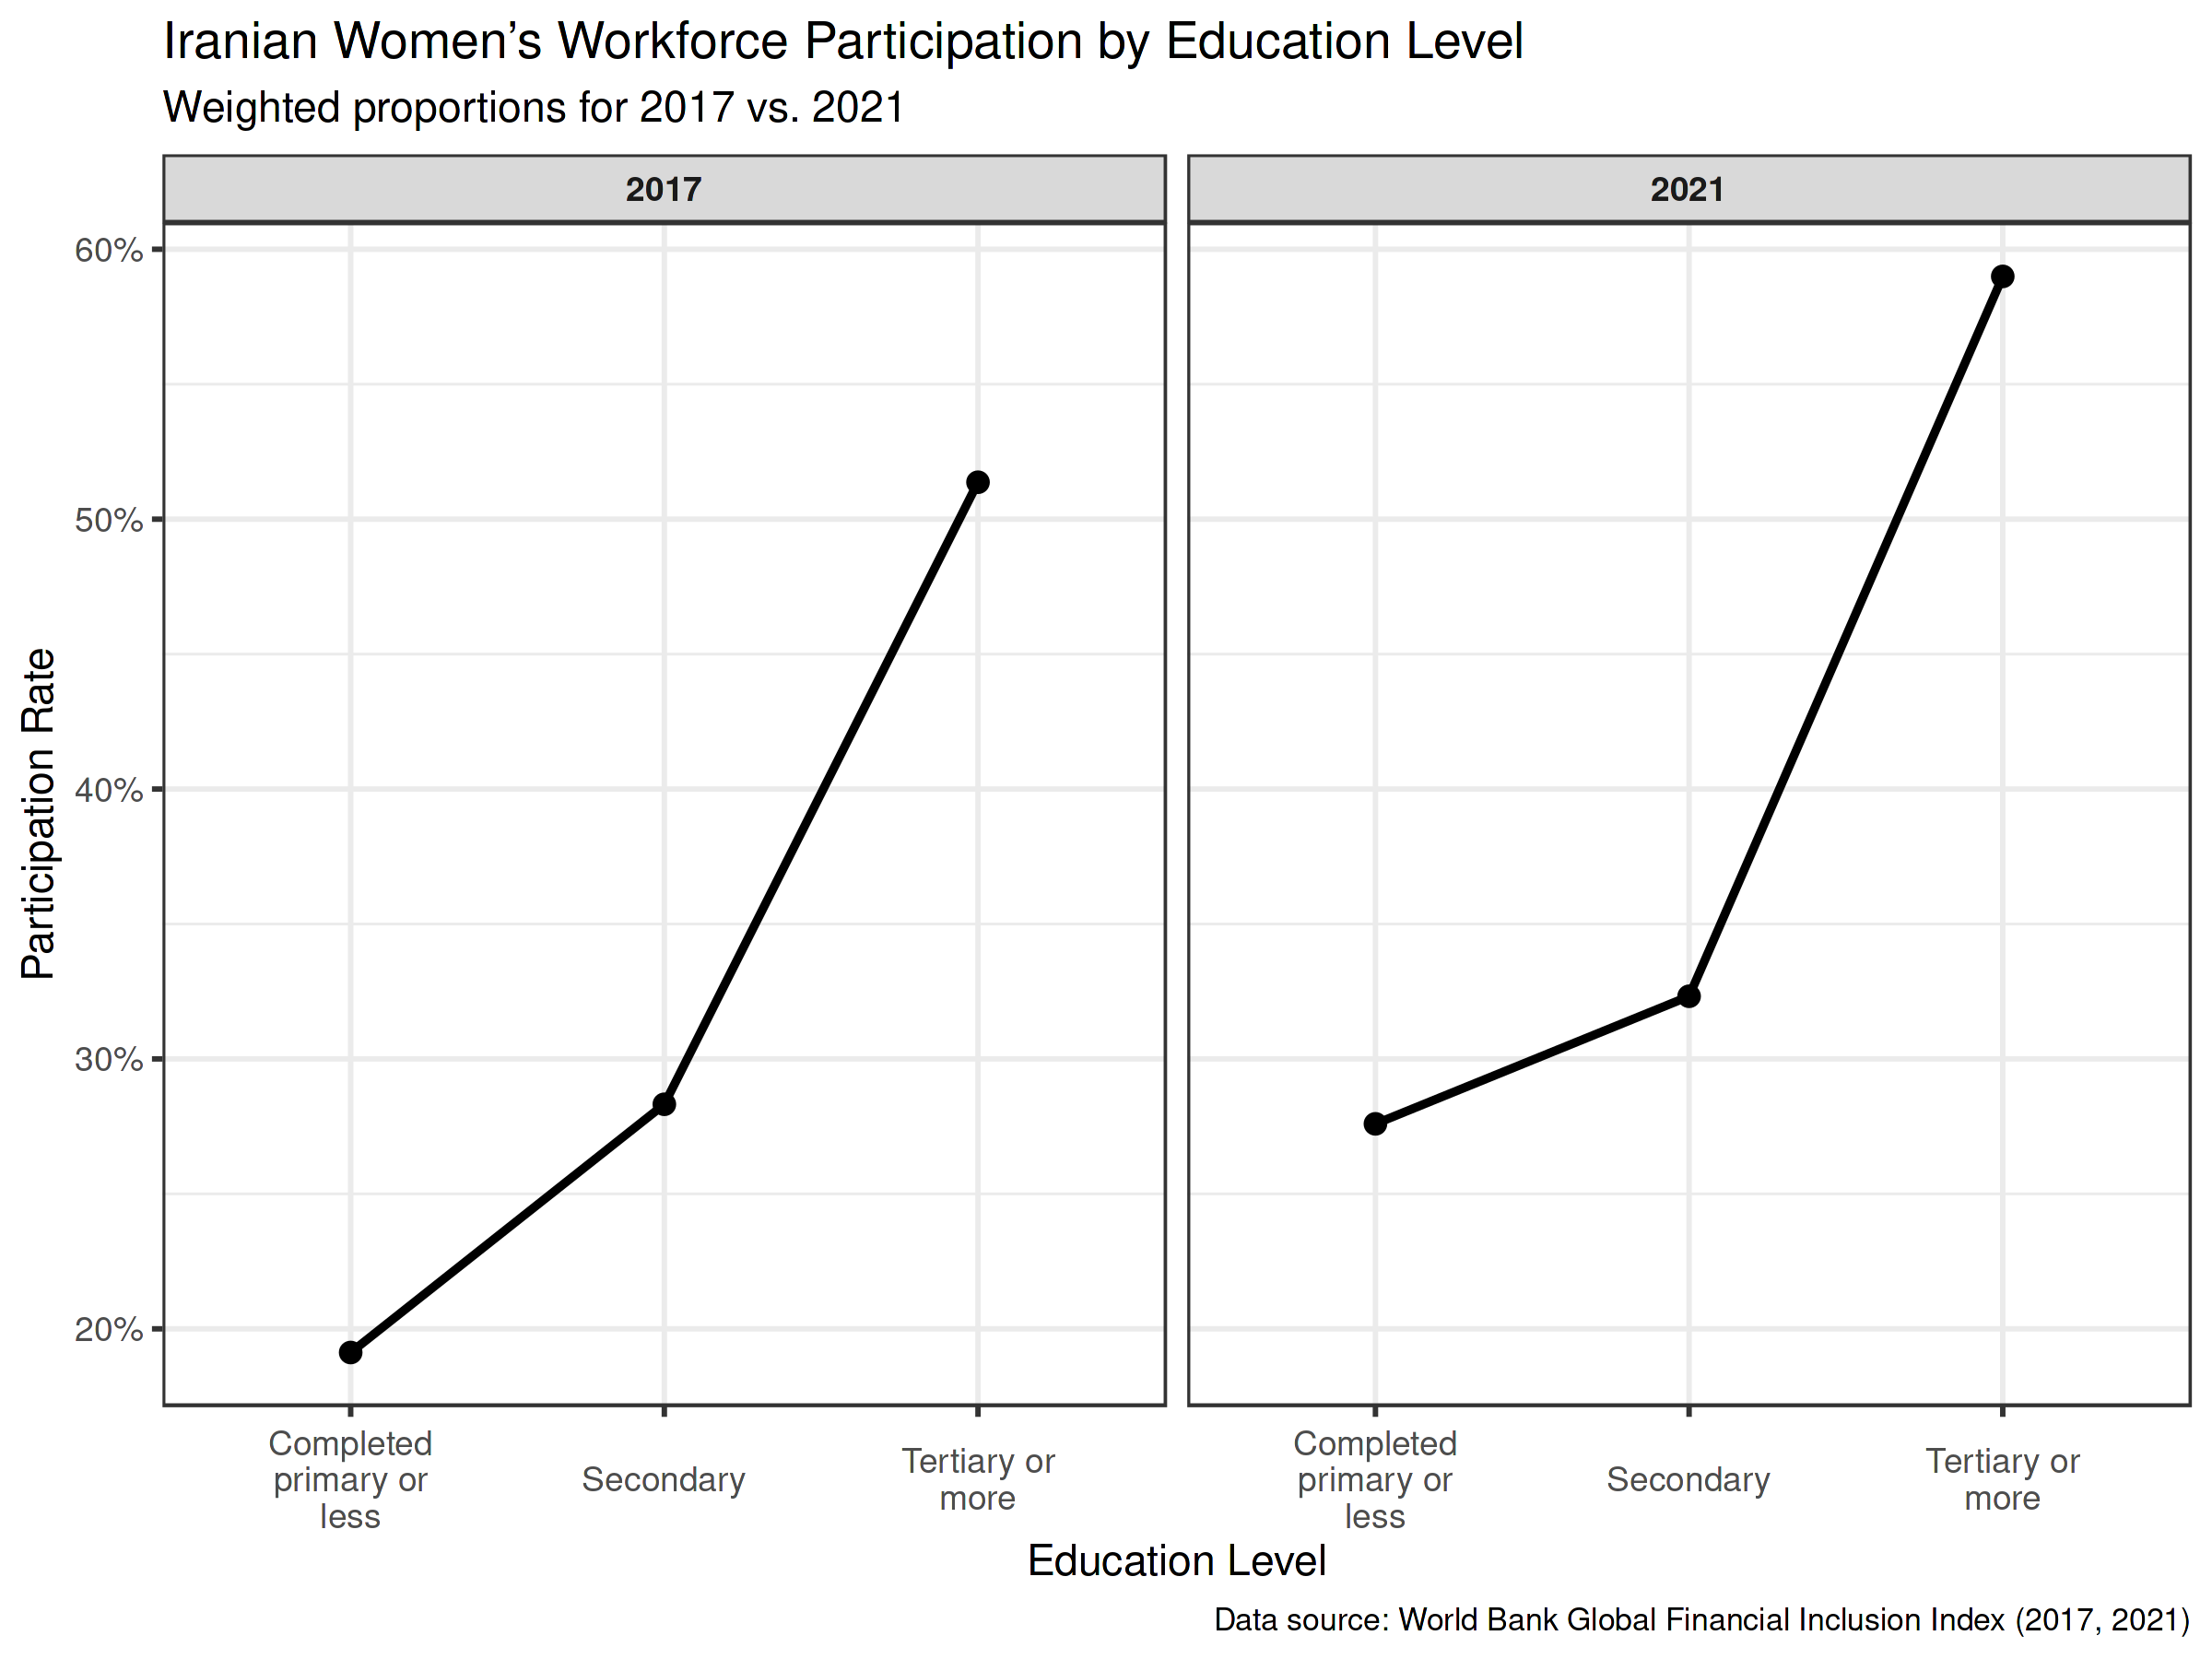

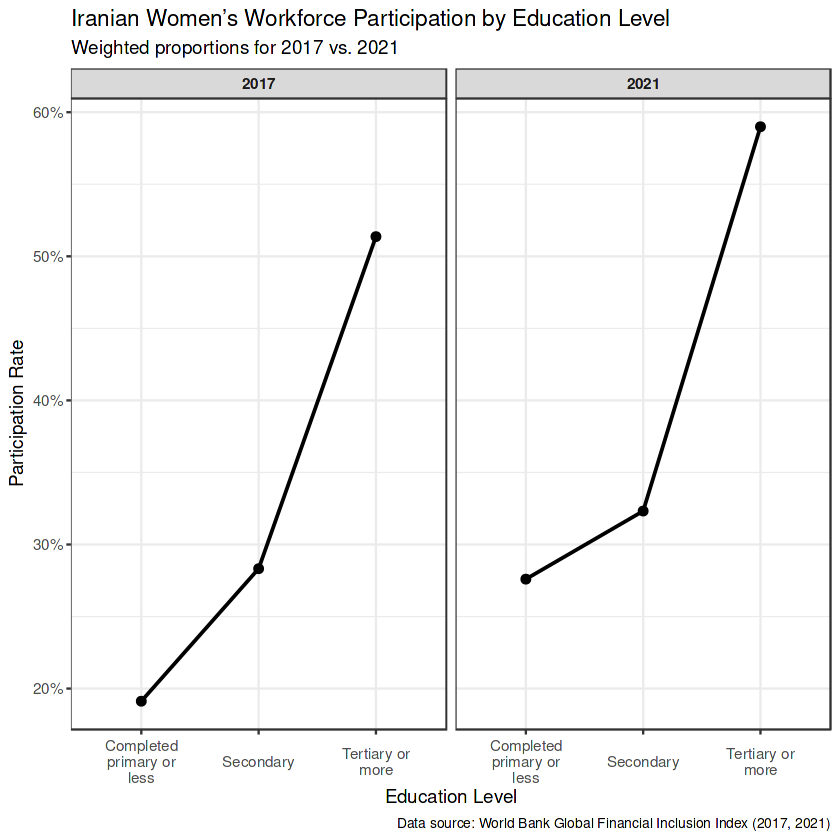

In [3]:
education_plot <- gfi_tbl |>
  filter(!is.na(respondent_education_level_o)) |>
  mutate(
    education = factor(
      respondent_education_level_o,
      levels = c(0, 1, 2),
      labels = c(
        "Completed primary or less",
        "Secondary",
        "Tertiary or more"
      )
    )
  ) |>
  group_by(year_b, education) |>
  summarise(
    participation = sum(in_the_workforce_b * weight_d) / sum(weight_d),
    .groups = "drop"
  ) |>
  ggplot(aes(
    x     = education,
    y     = participation,
    group = 1
  )) +
  geom_line(size = 0.8) +
  geom_point(size = 2) +
  facet_wrap(~ year_b) +
  scale_x_discrete(labels = wrap_format(15)) +   # wrap at ~15 characters
  scale_y_continuous(labels = percent_format(accuracy = 1)) +
  labs(
    title    = "Iranian Women’s Workforce Participation by Education Level",
    subtitle = "Weighted proportions for 2017 vs. 2021",
    x        = "Education Level",
    y        = "Participation Rate",
    caption  = "Data source: World Bank Global Financial Inclusion Index (2017, 2021)"
  ) +
  theme_bw() +
  theme(
    strip.text     = element_text(face = "bold"),
    axis.text.x    = element_text(angle = 0, vjust = 0.5, hjust = 0.5),  # no tilt
    plot.caption   = element_text(hjust = 1, size = 8)
  )

fig(education_plot,8,6,300,"education")


Saved plot to: /kaggle/working/output/account_type.png



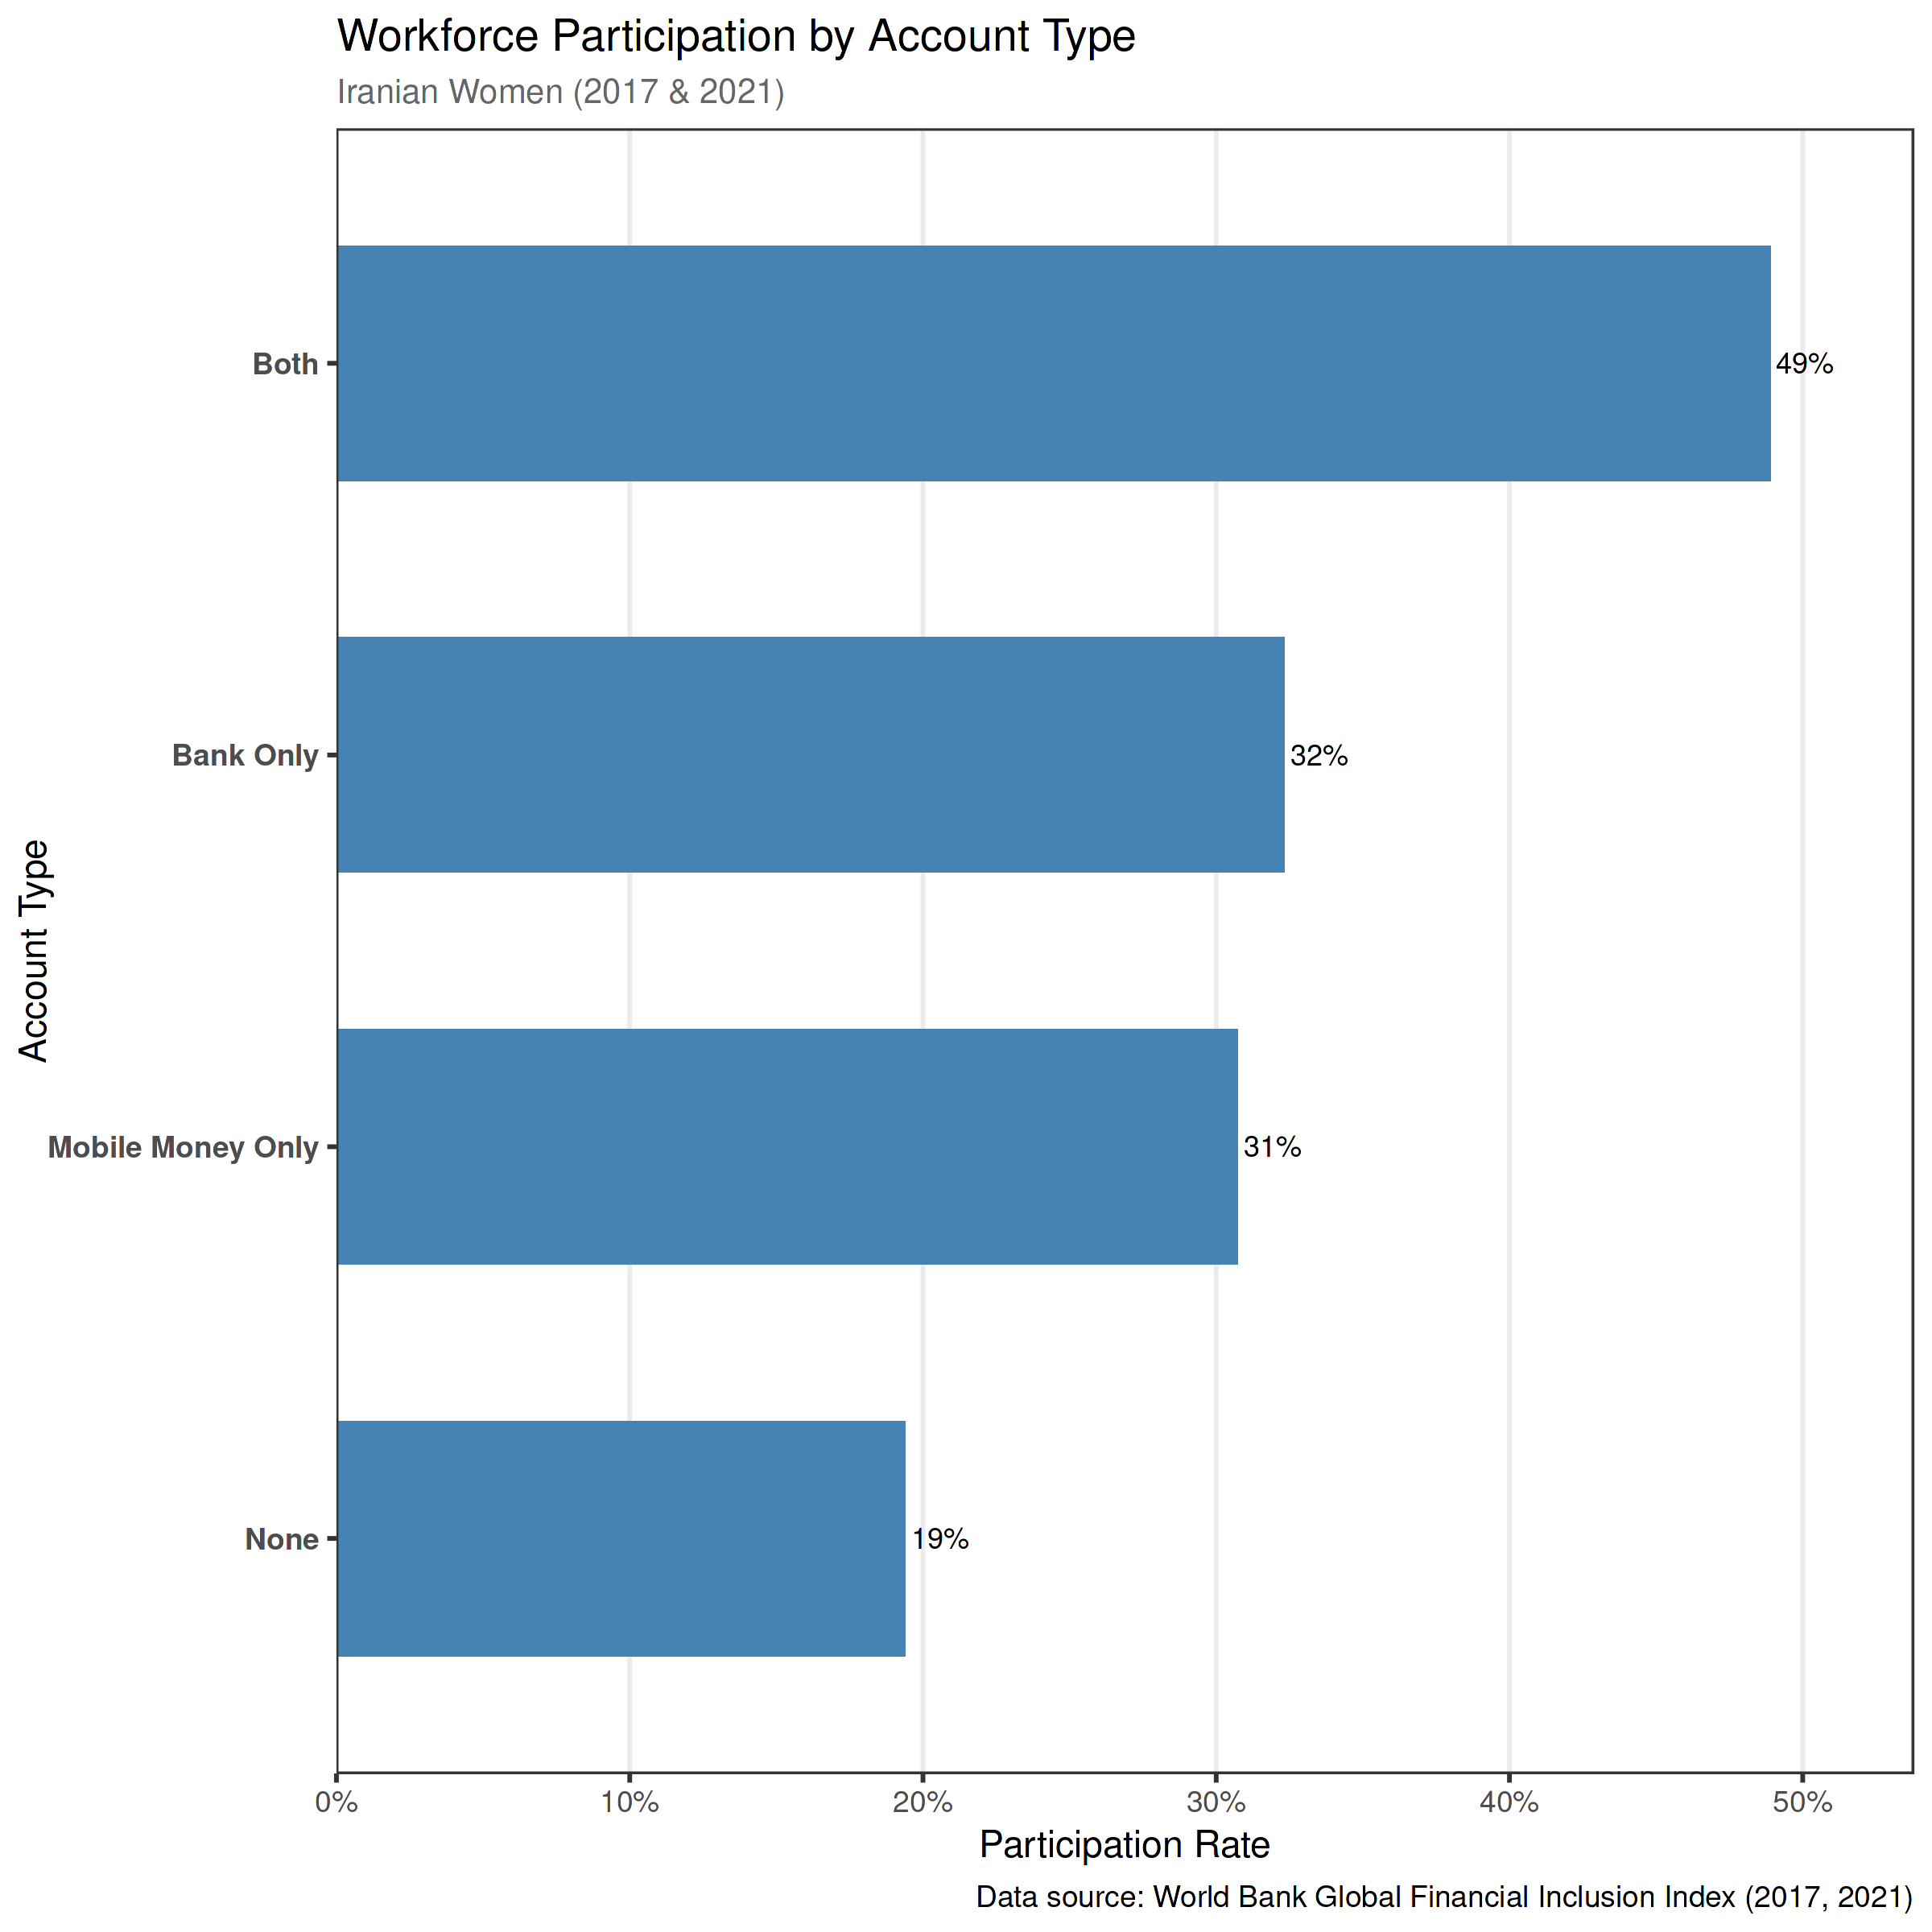

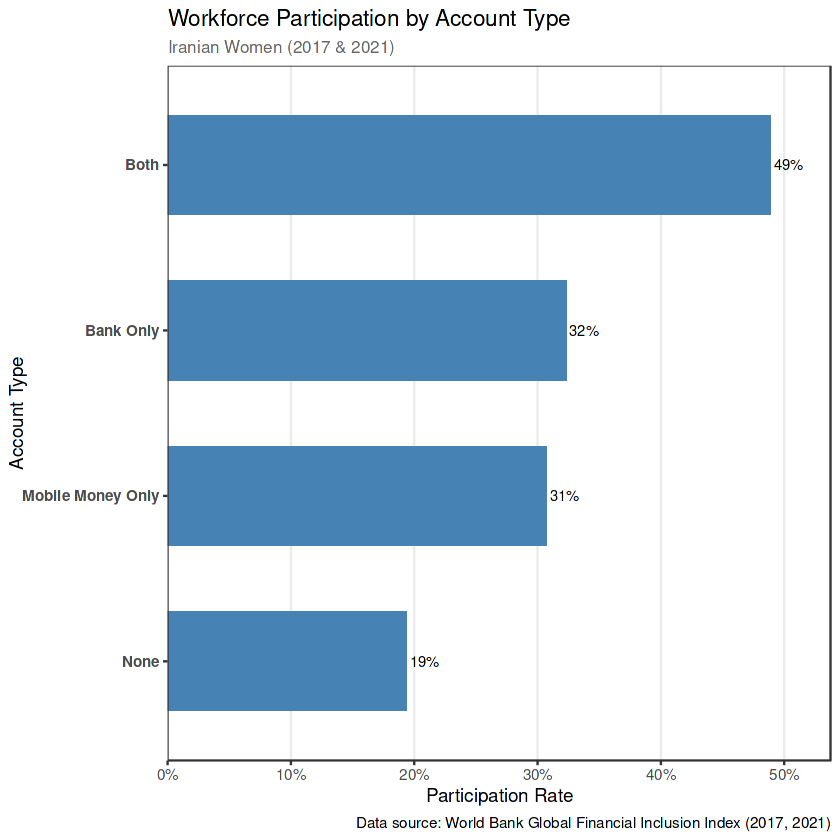

In [4]:
account_plot <- gfi_tbl |>
  mutate(
    account_type = case_when(
      has_financial_institution_account_b == 1 & has_mobile_money_account_b == 1 ~ "Both",
      has_financial_institution_account_b == 1                            ~ "Bank Only",
      has_mobile_money_account_b == 1                                    ~ "Mobile Money Only",
      TRUE                                                              ~ "None"
    )
  ) |>
  group_by(account_type) |>
  summarise(
    participation = sum(in_the_workforce_b * weight_d) / sum(weight_d),
    .groups = "drop"
  ) |>
  # Make sure we order from lowest to highest participation
  mutate(account_type = fct_reorder(account_type, participation)) |>
  ggplot(aes(x = account_type, y = participation)) +
    geom_col(width = 0.6, fill = "steelblue") +
    geom_text(
      aes(label = percent(participation, accuracy = 1)),
      hjust = -0.1,
      size = 3
    ) +
    scale_y_continuous(
      labels = percent_format(accuracy = 1),
      expand = expansion(mult = c(0, 0.1))
    ) +
    labs(
      title    = "Workforce Participation by Account Type",
      subtitle = "Iranian Women (2017 & 2021)",
      x        = "Account Type",
      y        = "Participation Rate",
      caption  = "Data source: World Bank Global Financial Inclusion Index (2017, 2021)"
    ) +
    theme_bw() +
    theme(
      panel.grid.major.y = element_blank(),
      panel.grid.minor   = element_blank(),
      axis.text.y        = element_text(face = "bold"),
      plot.subtitle      = element_text(size = rel(0.9), color = "gray40")
    ) +
    coord_flip()

fig(account_plot,8,8,300,"account_type")


Saved plot to: /kaggle/working/output/saving.png



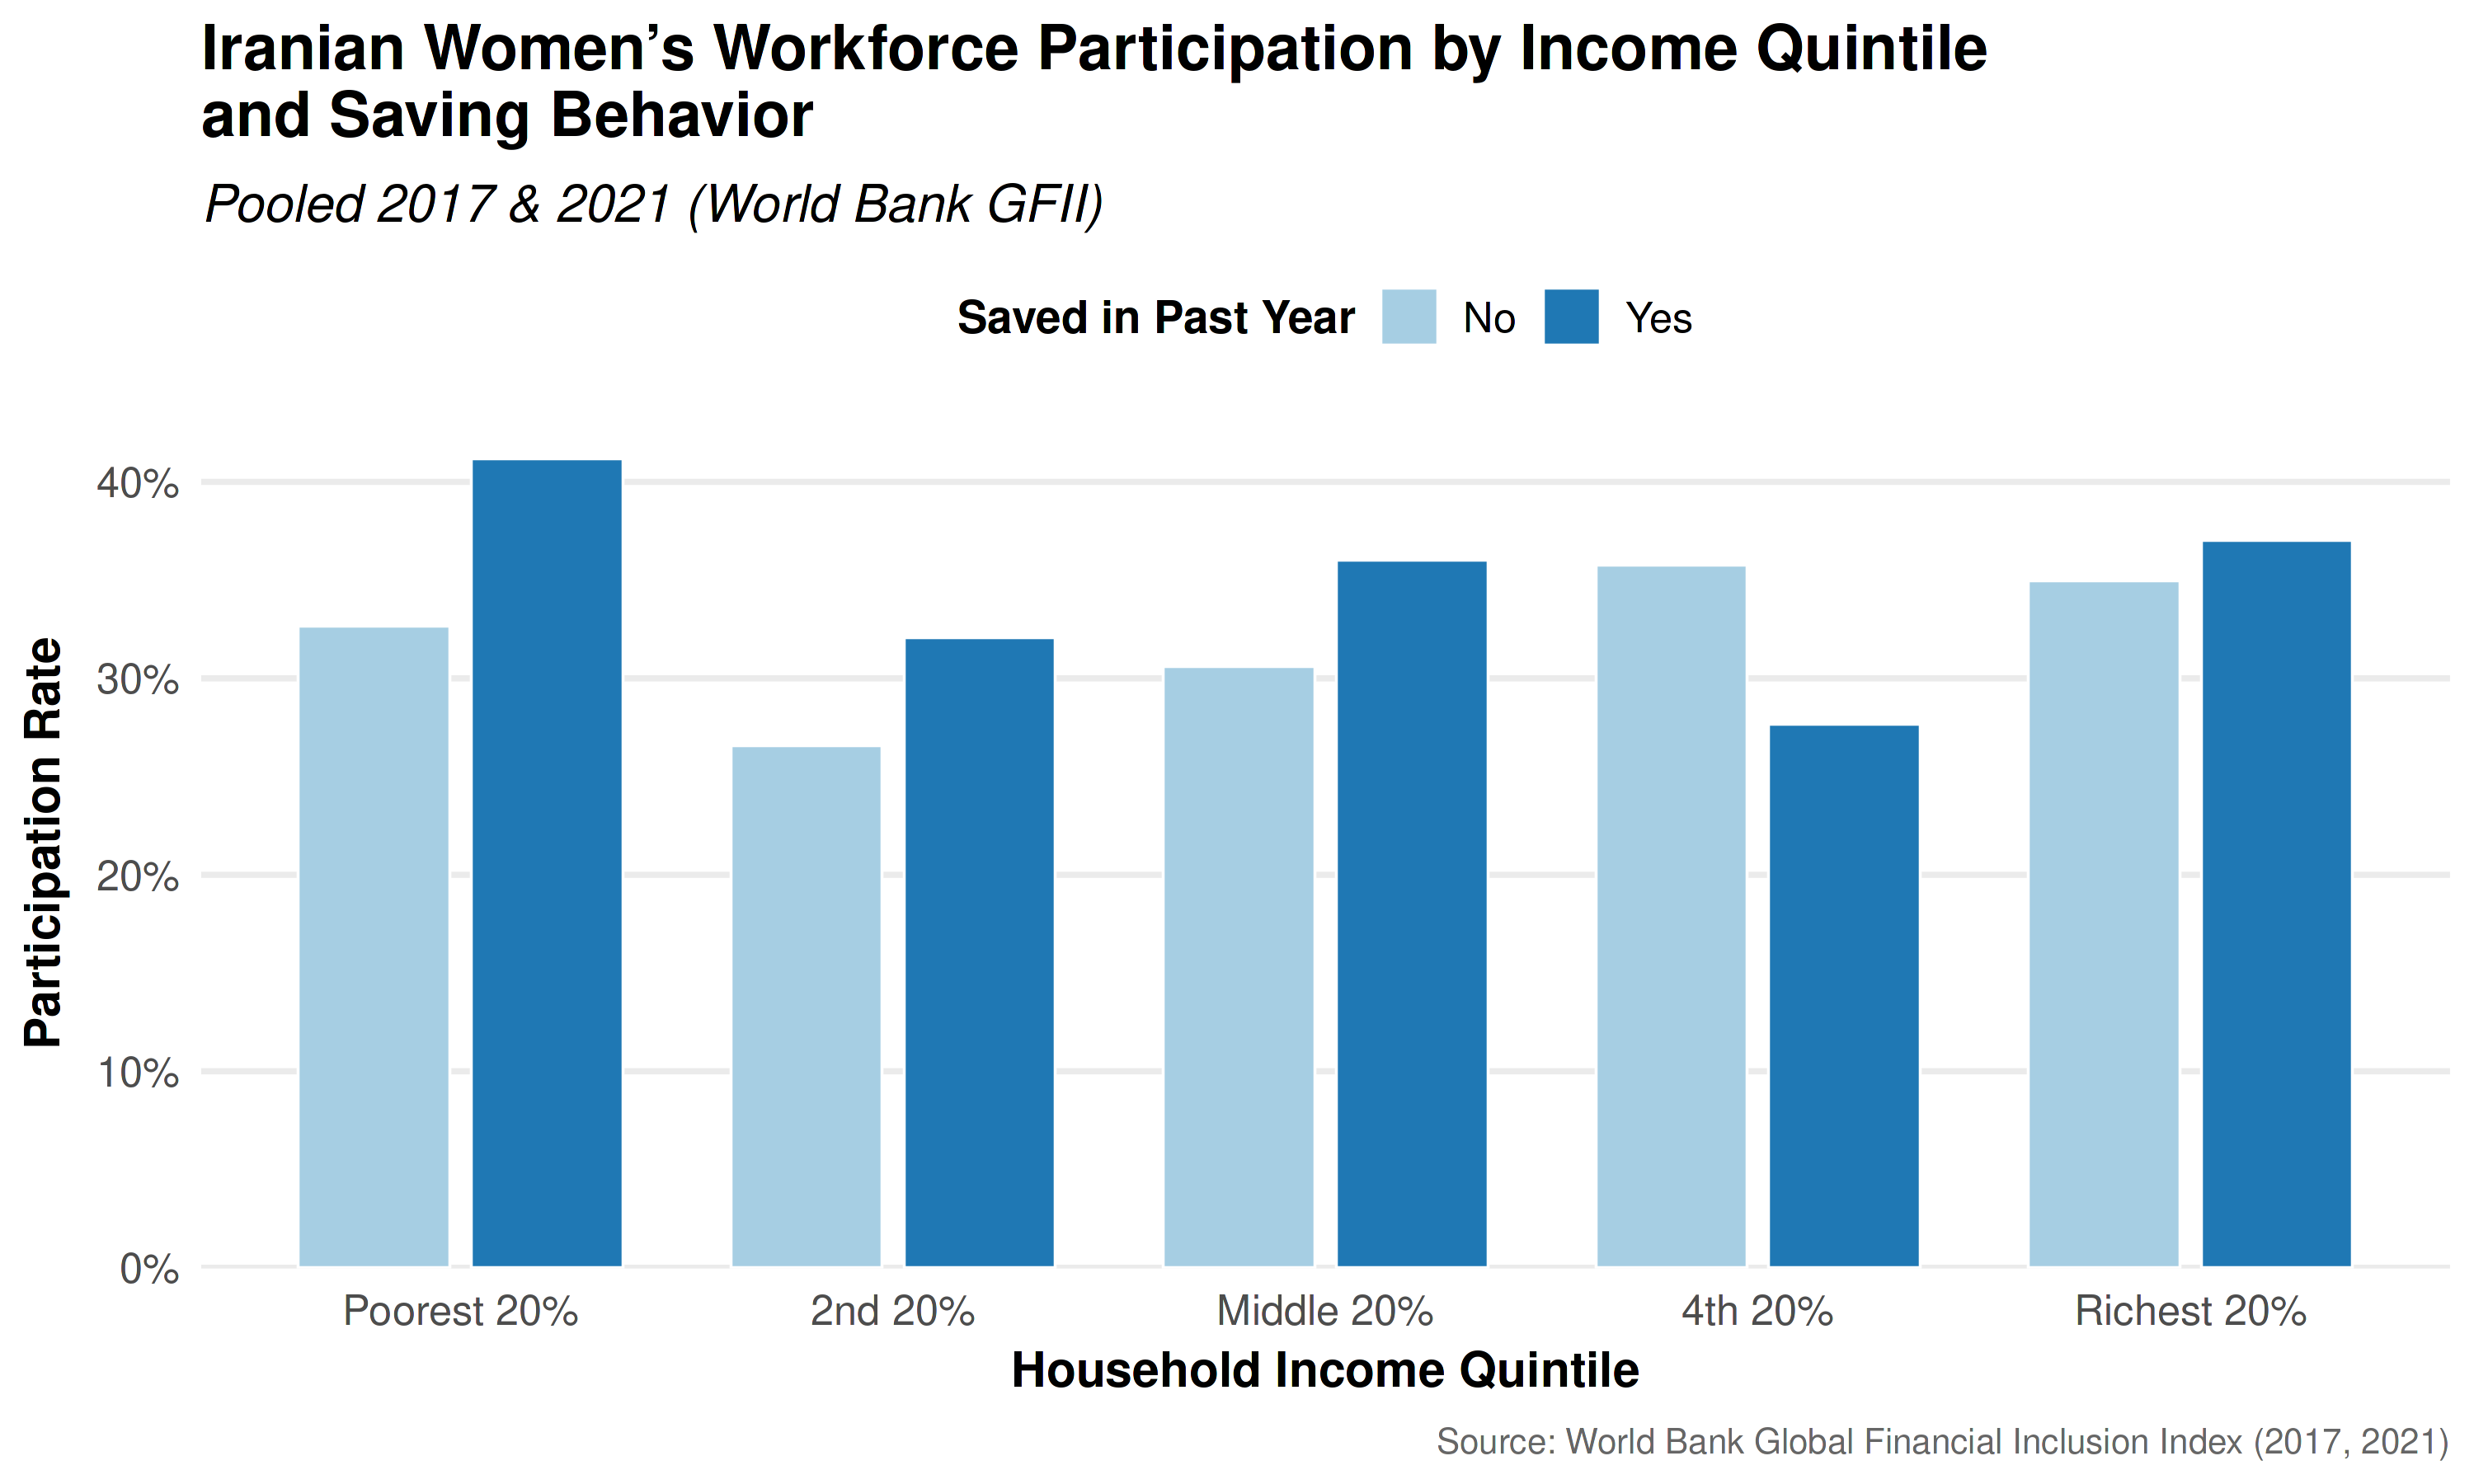

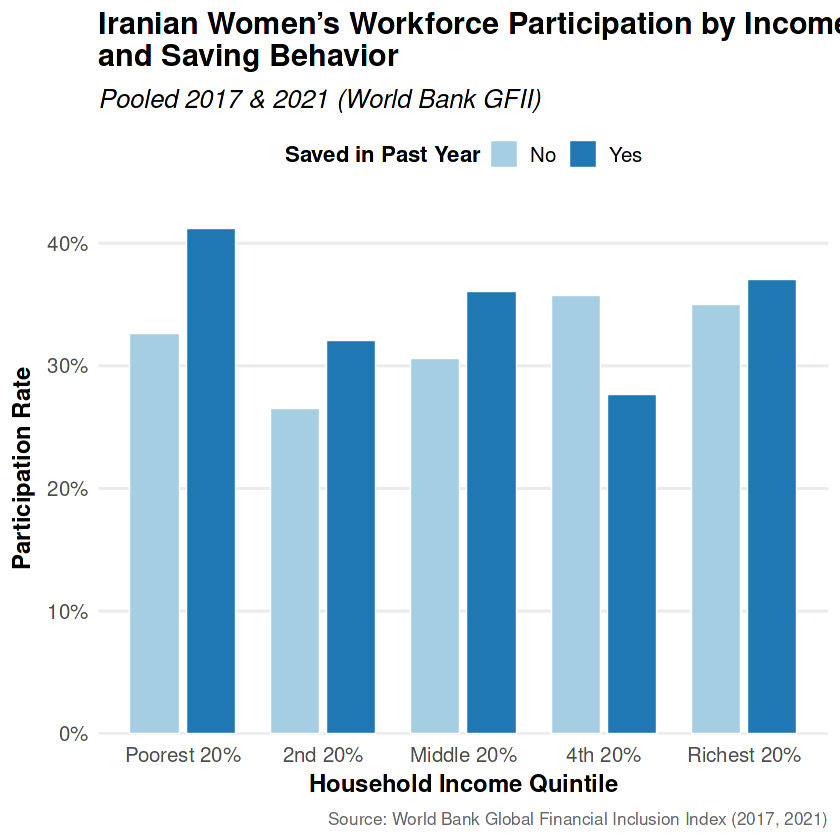

In [5]:
income_plot <- gfi_tbl |>
  # keep only non‐missing quintile and saved_in_past_year_b
  filter(
    !is.na(household_income_quintile_o),
    !is.na(saved_in_past_year_b)
  ) |>
  # pool across both survey years but split by saving status
  group_by(household_income_quintile_o, saved_in_past_year_b) |>
  summarise(
    participation = sum(in_the_workforce_b * weight_d) / sum(weight_d),
    .groups = "drop"
  ) |>
  # relabel quintile and saving status
  mutate(
    household_income_quintile = factor(
      household_income_quintile_o,
      levels = 0:4,
      labels = c("Poorest 20%", "2nd 20%", "Middle 20%",
                 "4th 20%", "Richest 20%")
    ),
    saved = factor(
      saved_in_past_year_b,
      levels = c(0, 1),
      labels = c("No", "Yes")
    )
  ) |>
  ggplot(aes(
    x    = household_income_quintile,
    y    = participation,
    fill = saved
  )) +
    geom_col(
      position = position_dodge(width = 0.8),
      width    = 0.7,
      colour   = "white",
      size     = 0.3
    ) +
    scale_fill_brewer(
      palette = "Paired",
      name    = "Saved in Past Year"
    ) +
    scale_y_continuous(
      labels = scales::percent_format(accuracy = 1),
      expand = expansion(mult = c(0, 0.05))
    ) +
    labs(
      title    = "Iranian Women’s Workforce Participation by Income Quintile\nand Saving Behavior",
      subtitle = "Pooled 2017 & 2021 (World Bank GFII)",
      x        = "Household Income Quintile",
      y        = "Participation Rate",
      caption  = "Source: World Bank Global Financial Inclusion Index (2017, 2021)"
    ) +
    theme_minimal(base_size = 14) +
    theme(
      legend.position       = "top",
      legend.title          = element_text(size = 13, face = "bold"),
      legend.text           = element_text(size = 12),
      plot.title            = element_text(size = 18, face = "bold", margin = margin(b = 10)),
      plot.subtitle         = element_text(size = 15, face = "italic", margin = margin(b = 8)),
      plot.caption          = element_text(size = 10, color = "gray40", margin = margin(t = 8)),
      axis.title.x          = element_text(size = 14, face = "bold", margin = margin(t = 6)),
      axis.title.y          = element_text(size = 14, face = "bold", margin = margin(r = 6)),
      axis.text.x           = element_text(size = 12, angle = 0, vjust = 0.5),
      axis.text.y           = element_text(size = 12),
      panel.grid.major.x    = element_blank(),
      panel.grid.minor      = element_blank()
    )

fig(income_plot,10,6,300,"saving")


Saved plot to: /kaggle/working/output/emergency_funds.png



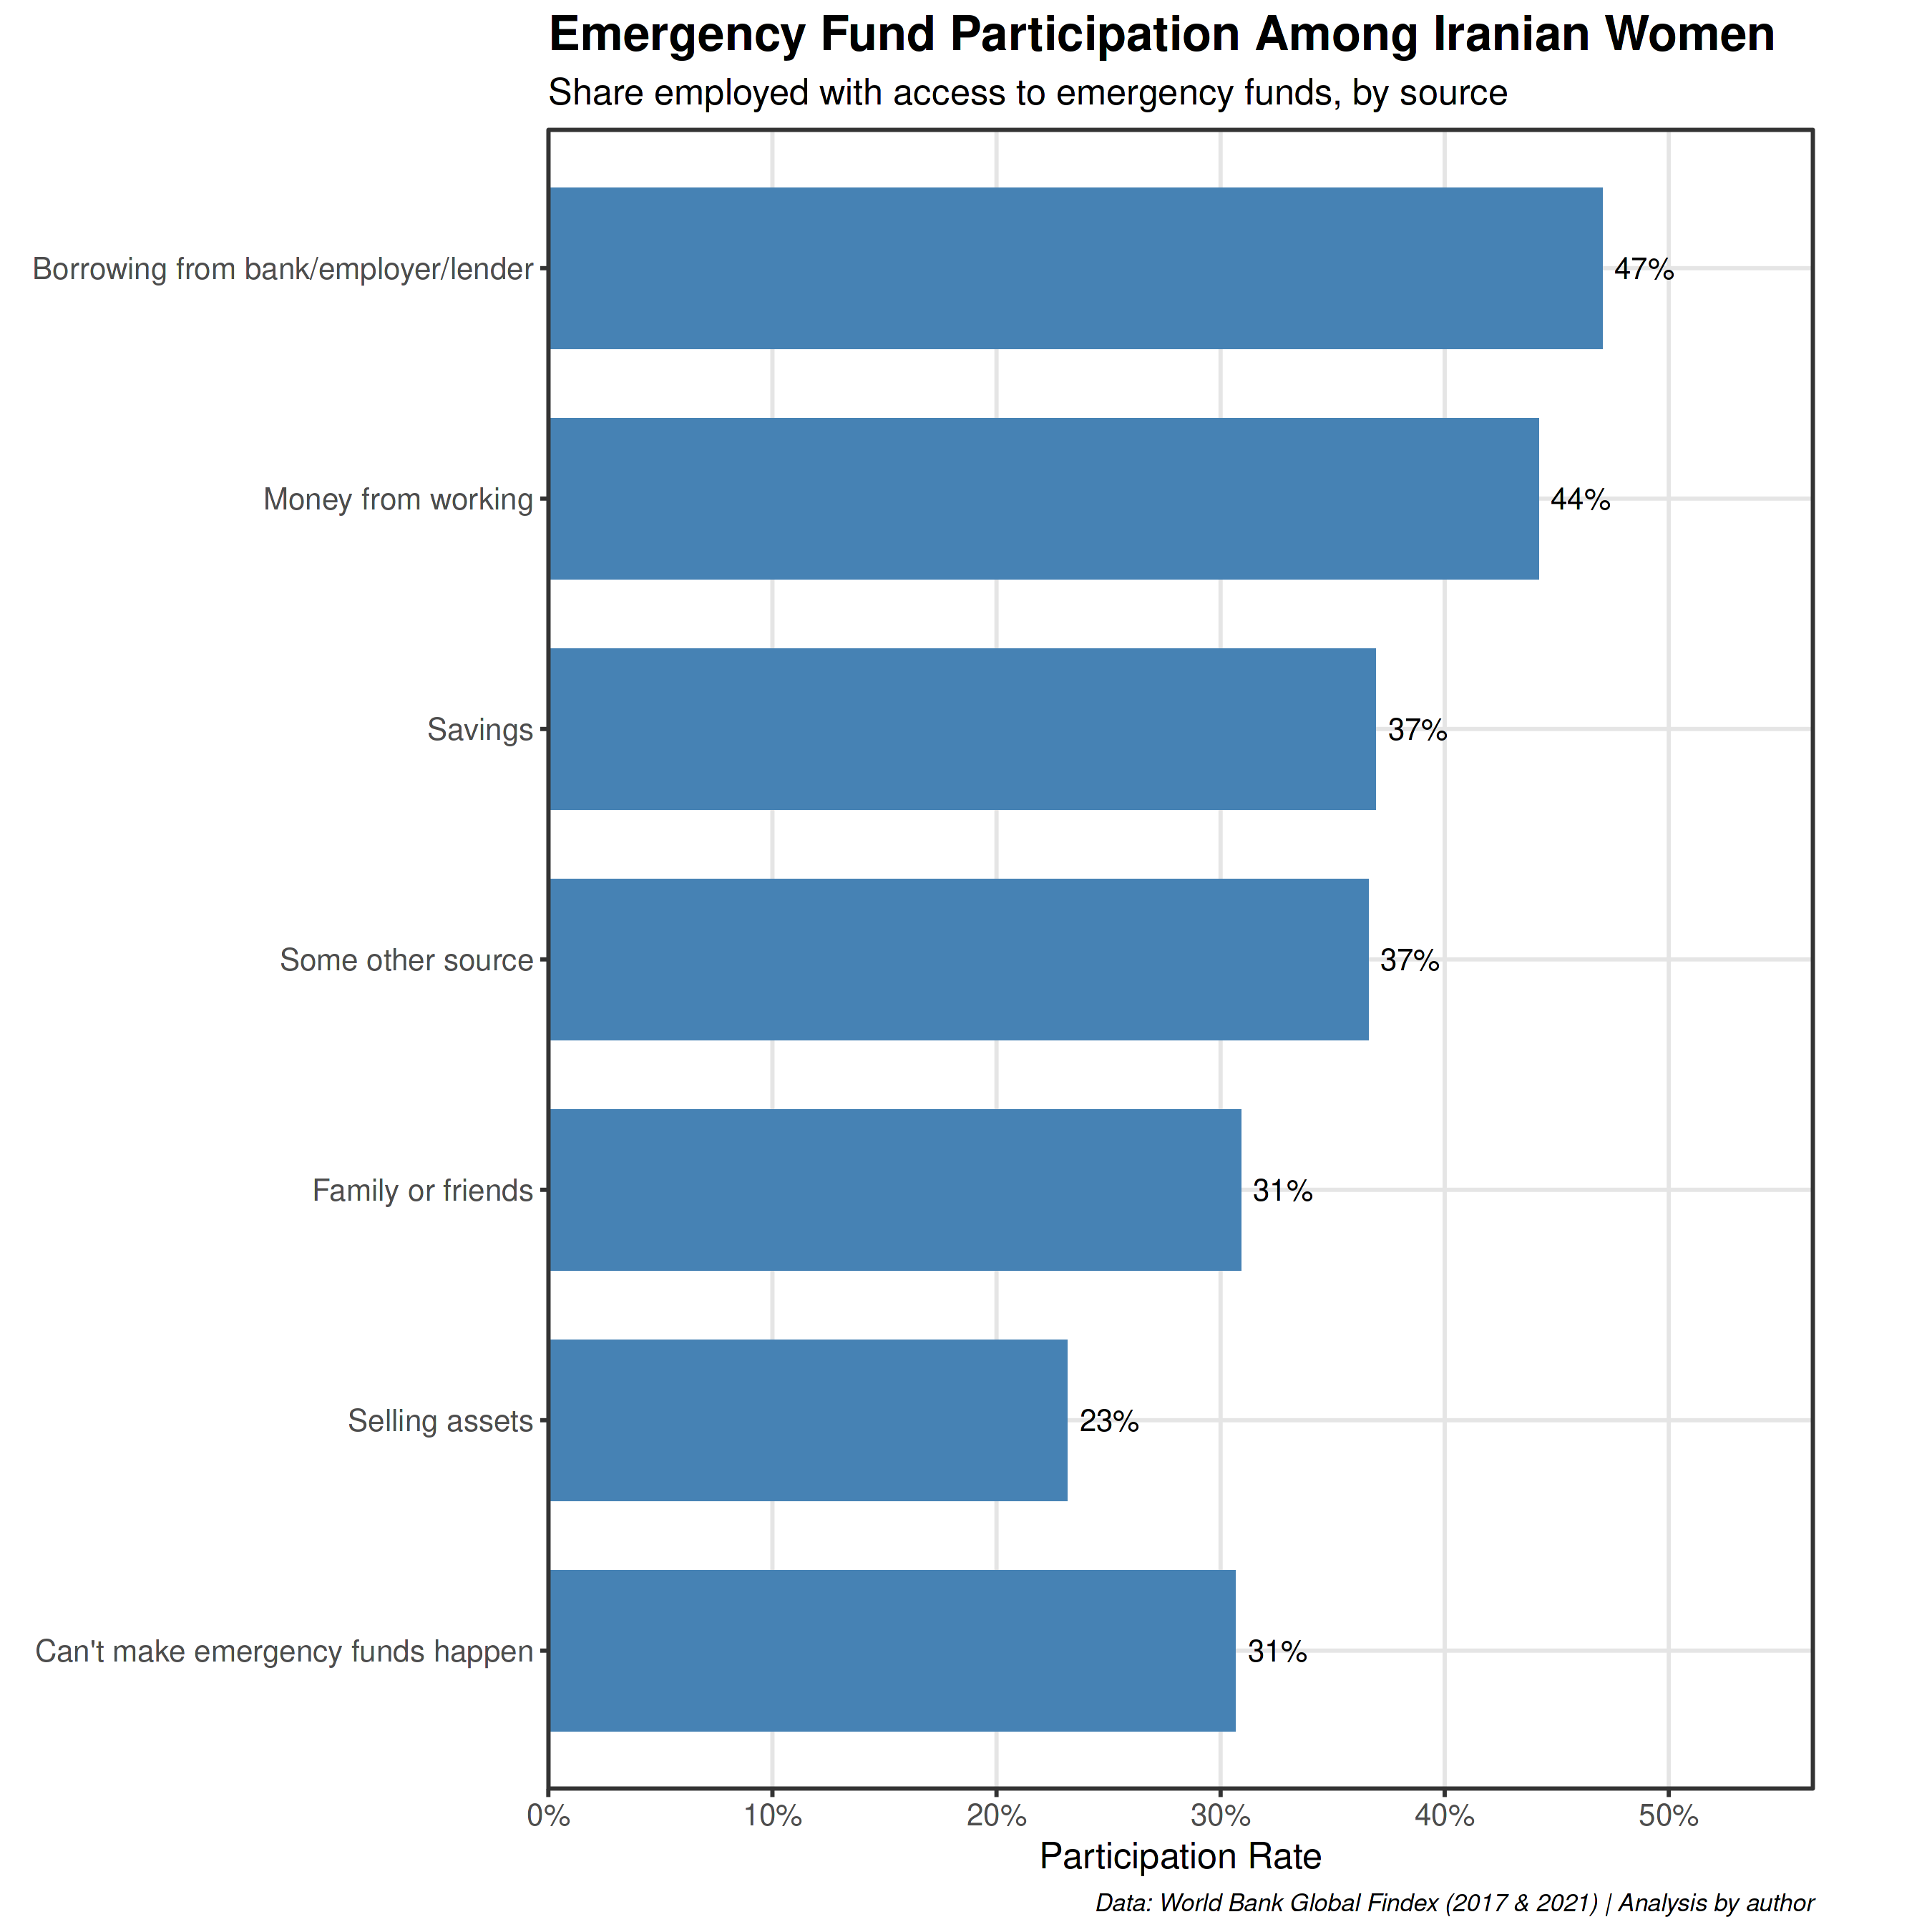

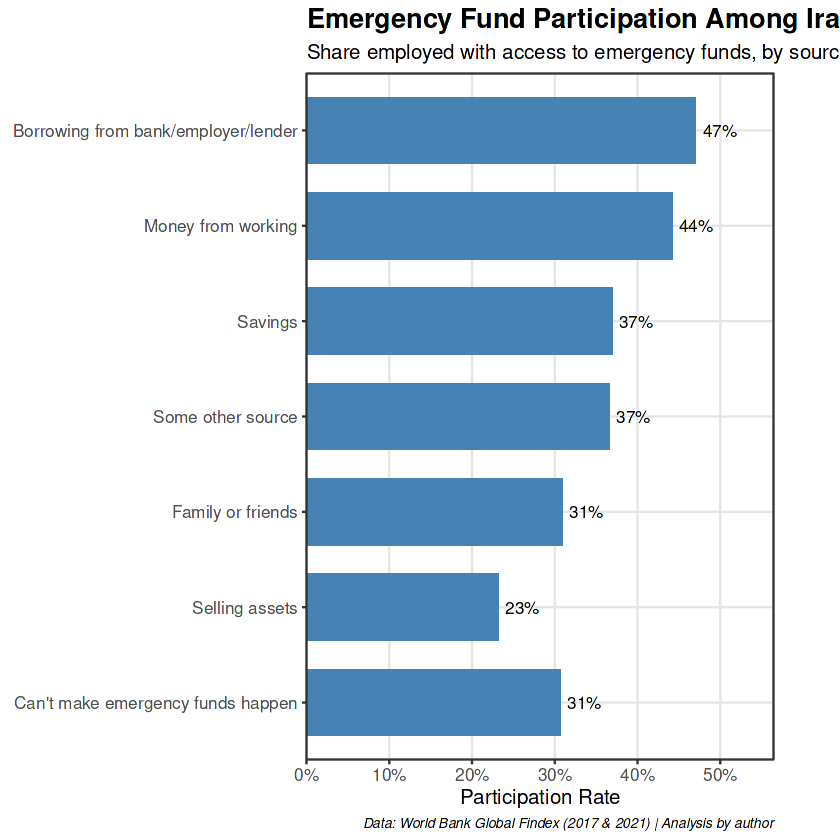

In [6]:
# mapping codes → full labels
fund_labels <- c(
  "0" = "Can't make emergency funds happen",
  "1" = "Savings",
  "2" = "Family or friends",
  "3" = "Money from working",
  "4" = "Borrowing from bank/employer/lender",
  "5" = "Selling assets",
  "6" = "Some other source"
)

funds_plot <- gfi_tbl |>
  filter(!is.na(main_source_emergency_funds_c)) |>
  group_by(main_source_emergency_funds_c) |>
  summarise(
    participation = sum(in_the_workforce_b * weight_d) / sum(weight_d),
    .groups = "drop"
  ) |>
  ggplot(aes(
    x = participation,
    y = reorder(
      main_source_emergency_funds_c,
      if_else(main_source_emergency_funds_c == 0, -1, participation)
    )
  )) +
  geom_col(width = 0.7, fill = "steelblue") +
  geom_text(
    aes(label = percent(participation, accuracy = 1)),
    hjust    = -0.2,
    nudge_x  =  0,
    size     =  3.5,
    color    = "black"
  ) +
  scale_y_discrete(labels = fund_labels) +
  scale_x_continuous(
    labels = percent_format(accuracy = 1),
    expand = expansion(mult = c(0, 0.20))
  ) +
  coord_cartesian(clip = "off") +
  labs(
    title    = "Emergency Fund Participation Among Iranian Women",
    subtitle = "Share employed with access to emergency funds, by source",
    x        = "Participation Rate",
    y        = NULL,
    caption  = "Data: World Bank Global Findex (2017 & 2021) | Analysis by author"
  ) +
  theme_bw(base_size = 11) +
  theme(
    plot.title      = element_text(size = 16, face = "bold"),
    plot.subtitle   = element_text(size = 12),
    axis.text.y     = element_text(size = 10),
    axis.text.x     = element_text(size = 10),
    axis.title.x    = element_text(size = 12),
    plot.caption    = element_text(size = 8, face = "italic"),
    panel.grid.major = element_line(color = "gray90"),
    panel.grid.minor  = element_blank(),
    plot.margin      = margin(5, 40, 5, 5, "pt")
  )

fig(funds_plot,9,9,300,"emergency_funds")


Saved plot to: /kaggle/working/output/digital_payments.png



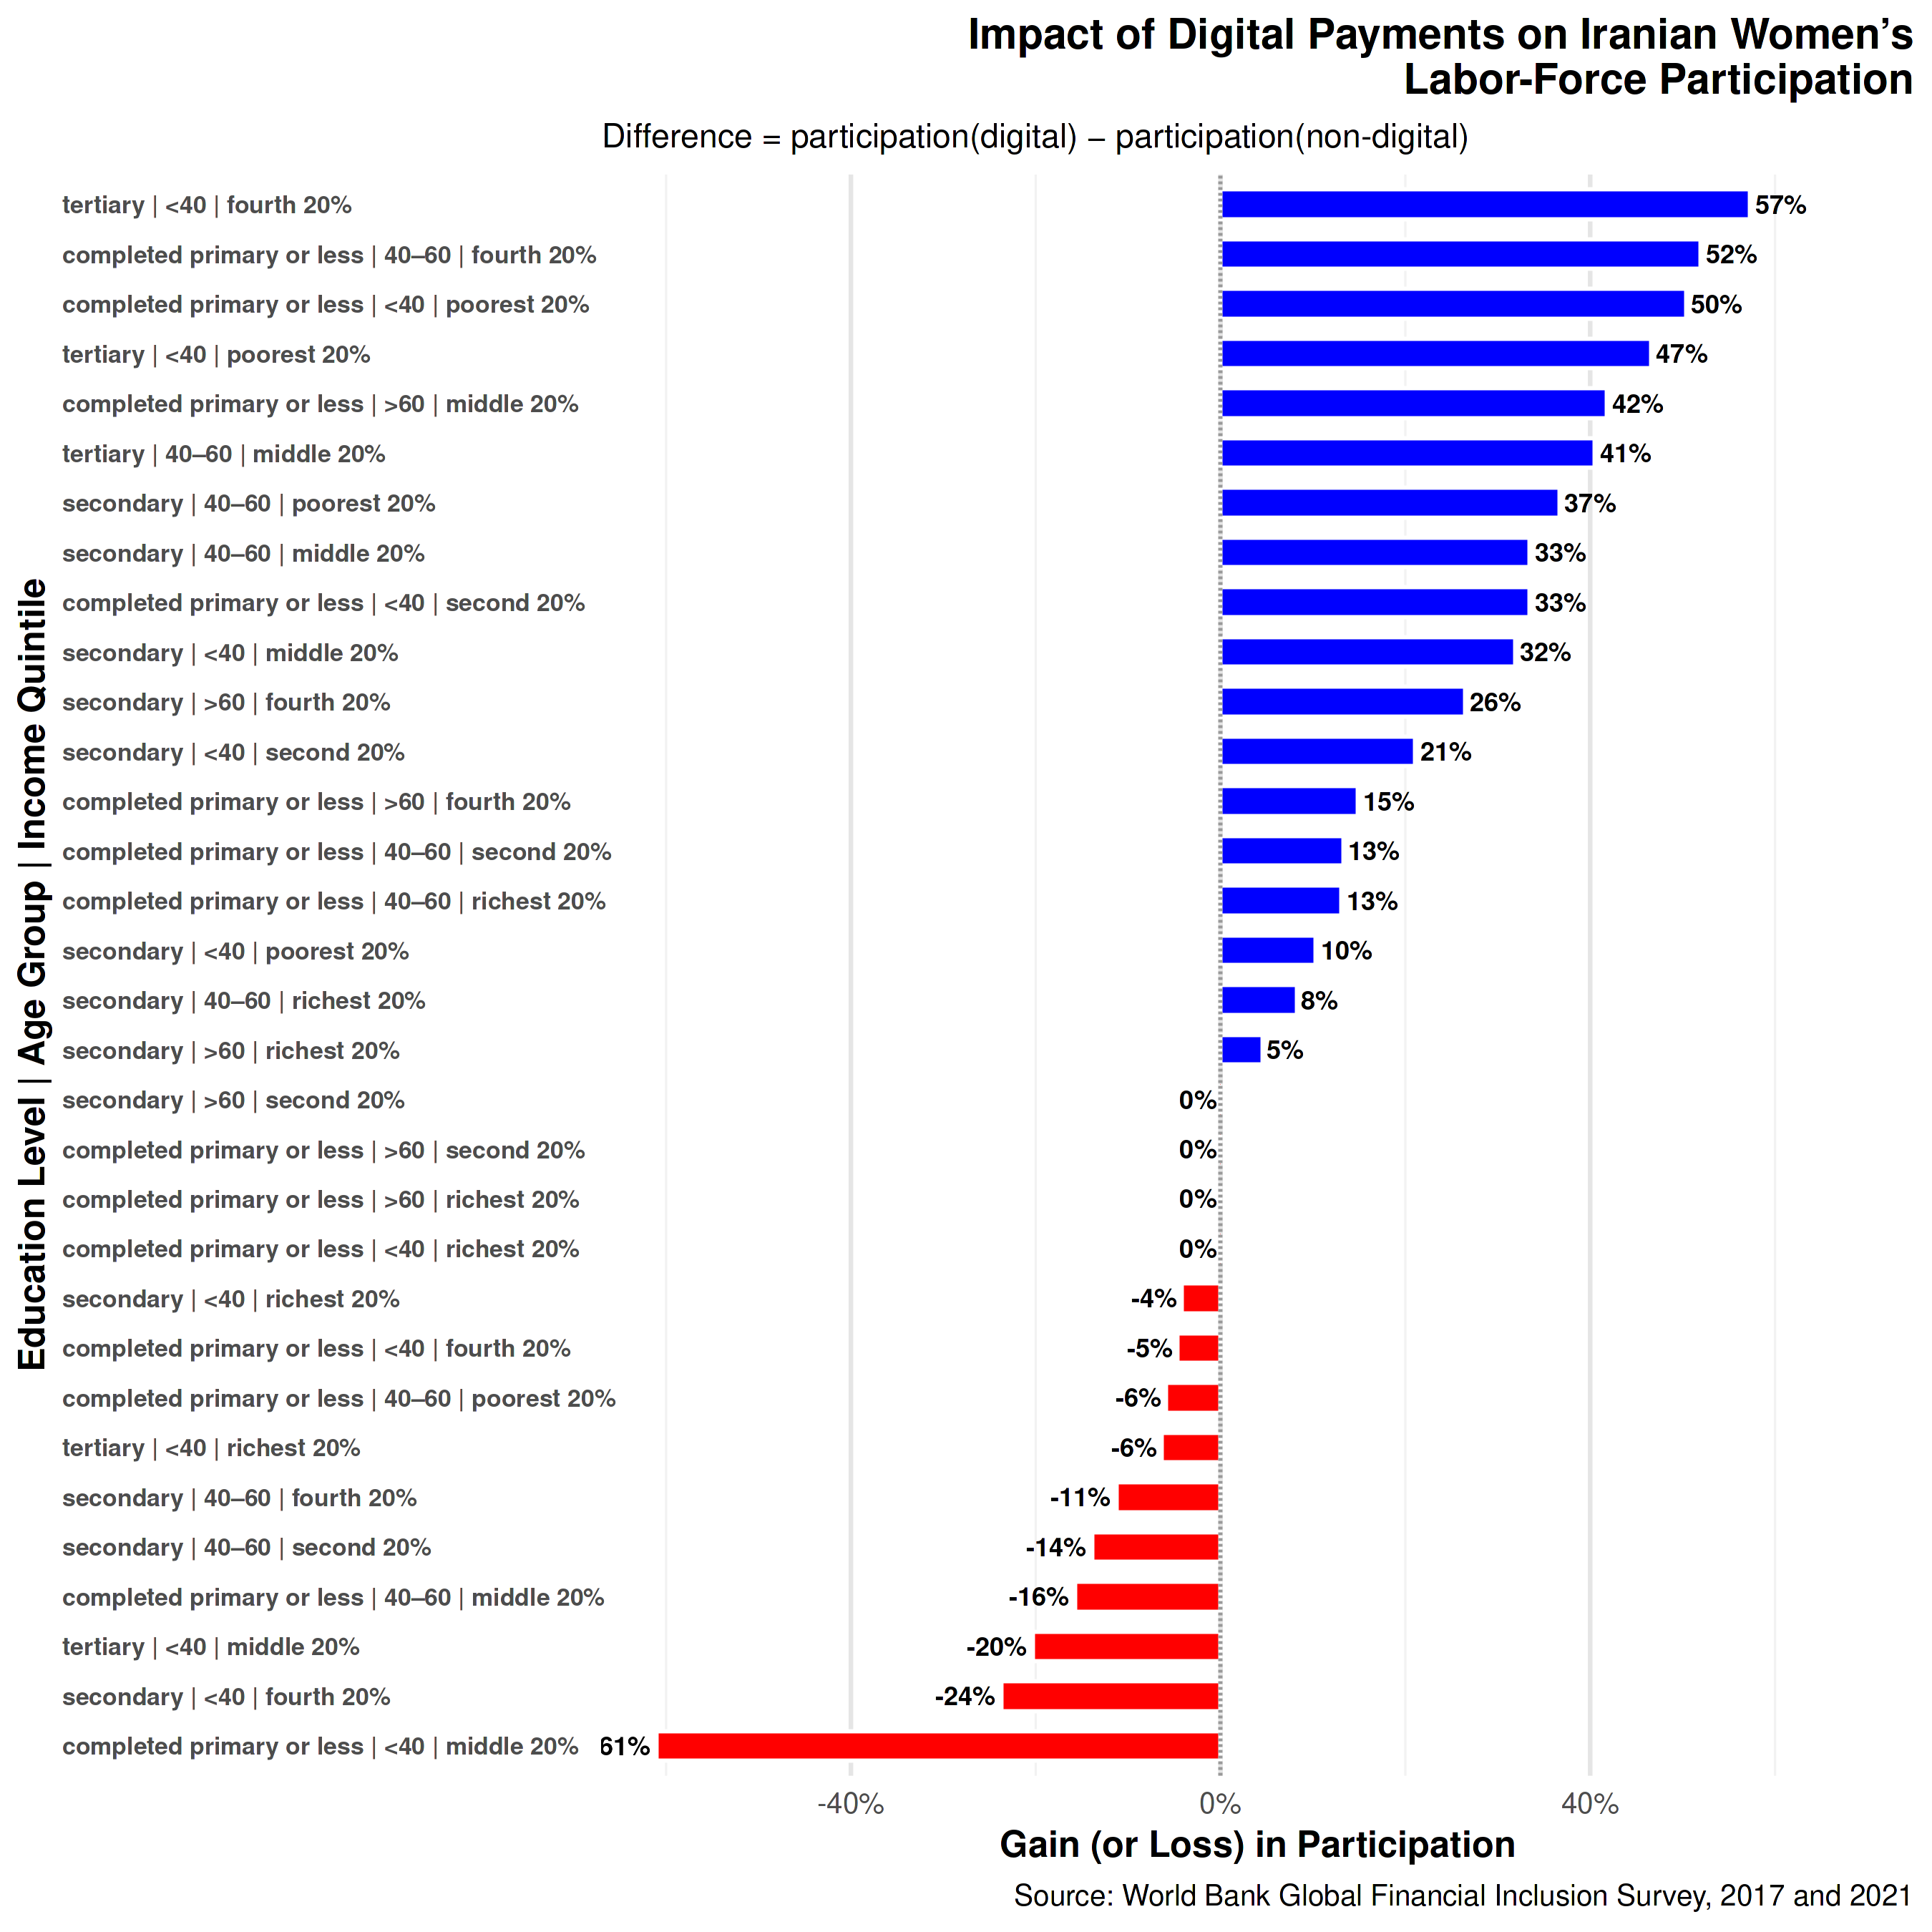

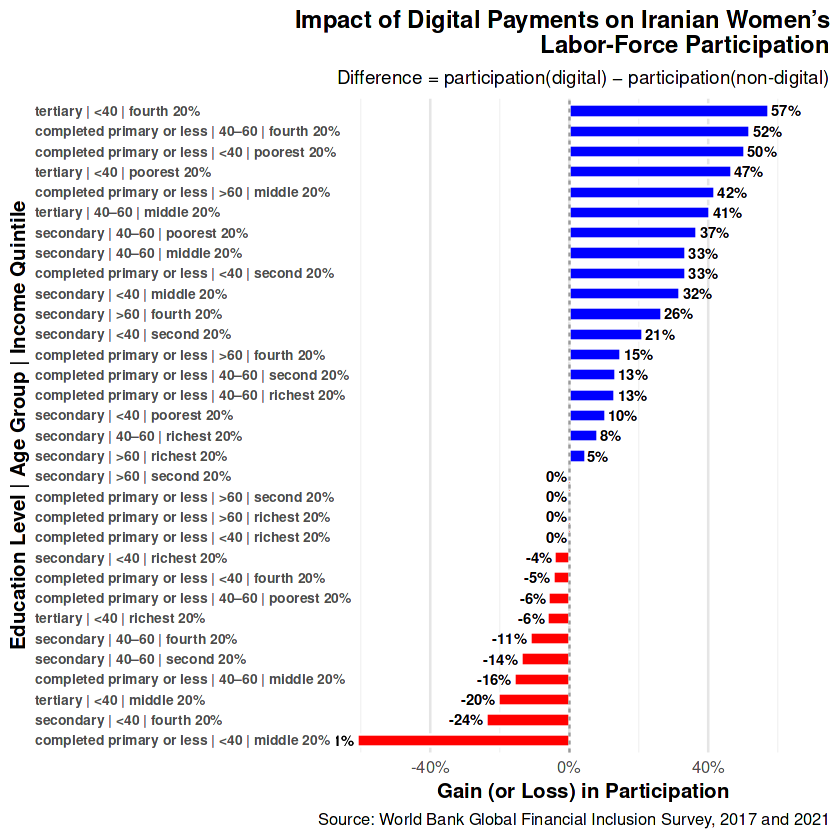

In [7]:
#–– 1. Compute the digital vs non‐digital difference ––#
demo_diff <- gfi_tbl |>
  mutate(
    age_bracket = case_when(
      respondent_age_o < 40                           ~ "<40",
      respondent_age_o >= 40 & respondent_age_o <= 60 ~ "40–60",
      respondent_age_o > 60                           ~ ">60"
    ),
    education = factor(
      respondent_education_level_o,
      levels = c(0, 1, 2),
      labels = c("completed primary or less", "secondary", "tertiary")
    ),
    income_quint = factor(
      household_income_quintile_o,
      levels = 0:4,
      labels = c("poorest 20%", "second 20%", "middle 20%",
                 "fourth 20%",  "richest 20%")
    ),
    demo = paste(education, age_bracket, income_quint, sep = " | ")
  ) |>
  as_survey_design(weights = weight_d) |>
  group_by(demo, made_or_received_digital_payment_b) |>
  summarise(labor_part = survey_mean(in_the_workforce_b, vartype = NULL)) |>
  ungroup() |>
  pivot_wider(
    names_from   = made_or_received_digital_payment_b,
    values_from  = labor_part,
    names_prefix = "dp_"
  ) |>
  filter(!is.na(dp_0) & !is.na(dp_1)) |>
  mutate(
    diff      = dp_1 - dp_0,
    bar_color = ifelse(diff > 0, "blue", "red"),
    demo      = reorder(demo, diff)
  )

digital_plot <- ggplot(demo_diff, aes(y = demo, x = diff, fill = bar_color)) +
  # bars with white outline
  geom_col(width = 0.6, color = "white") +
  # percentage labels
  geom_text(
    aes(label = percent(diff, accuracy = 1)),
    hjust = ifelse(demo_diff$diff > 0, -0.1, 1.1),
    size = 3, fontface = "bold"
  ) +
  # zero line
  geom_vline(xintercept = 0, color = "grey60", linetype = "dashed") +
  scale_fill_identity() +
  scale_x_continuous(
    labels = percent_format(accuracy = 1),
    expand = expansion(mult = c(0.05, 0.15))
  ) +
  labs(
    title    = "Impact of Digital Payments on Iranian Women’s\n Labor-Force Participation",
    subtitle = "Difference = participation(digital) − participation(non-digital)",
    x        = "Gain (or Loss) in Participation",
    y        = "Education Level | Age Group | Income Quintile",
    caption  = "Source: World Bank Global Financial Inclusion Survey, 2017 and 2021"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    # faded grid
    panel.grid.major.x = element_line(color = "grey90"),
    panel.grid.minor   = element_line(color = "grey95"),
    # left-align y labels, add a bit of padding
    axis.text.y         = element_text(size = 8, face = "bold", hjust = 0, margin = margin(r = 5)),
    # keep x-axis grid but remove horizontal lines on y
    panel.grid.major.y  = element_blank(),
    # bold titles & axis labels
    plot.title          = element_text(face = "bold", size = 14,hjust=1),
    plot.subtitle       = element_text(size = 11),
    axis.title.x        = element_text(face = "bold"),
    axis.title.y        = element_text(face = "bold")
  )

fig(digital_plot,9,9,300,"digital_payments")

Warning message:
“The `guide` argument in `scale_*()` cannot be `FALSE`. This was deprecated in
ggplot2 3.3.4.
ℹ Please use "none" instead.”


Saved plot to: /kaggle/working/output/reason.png



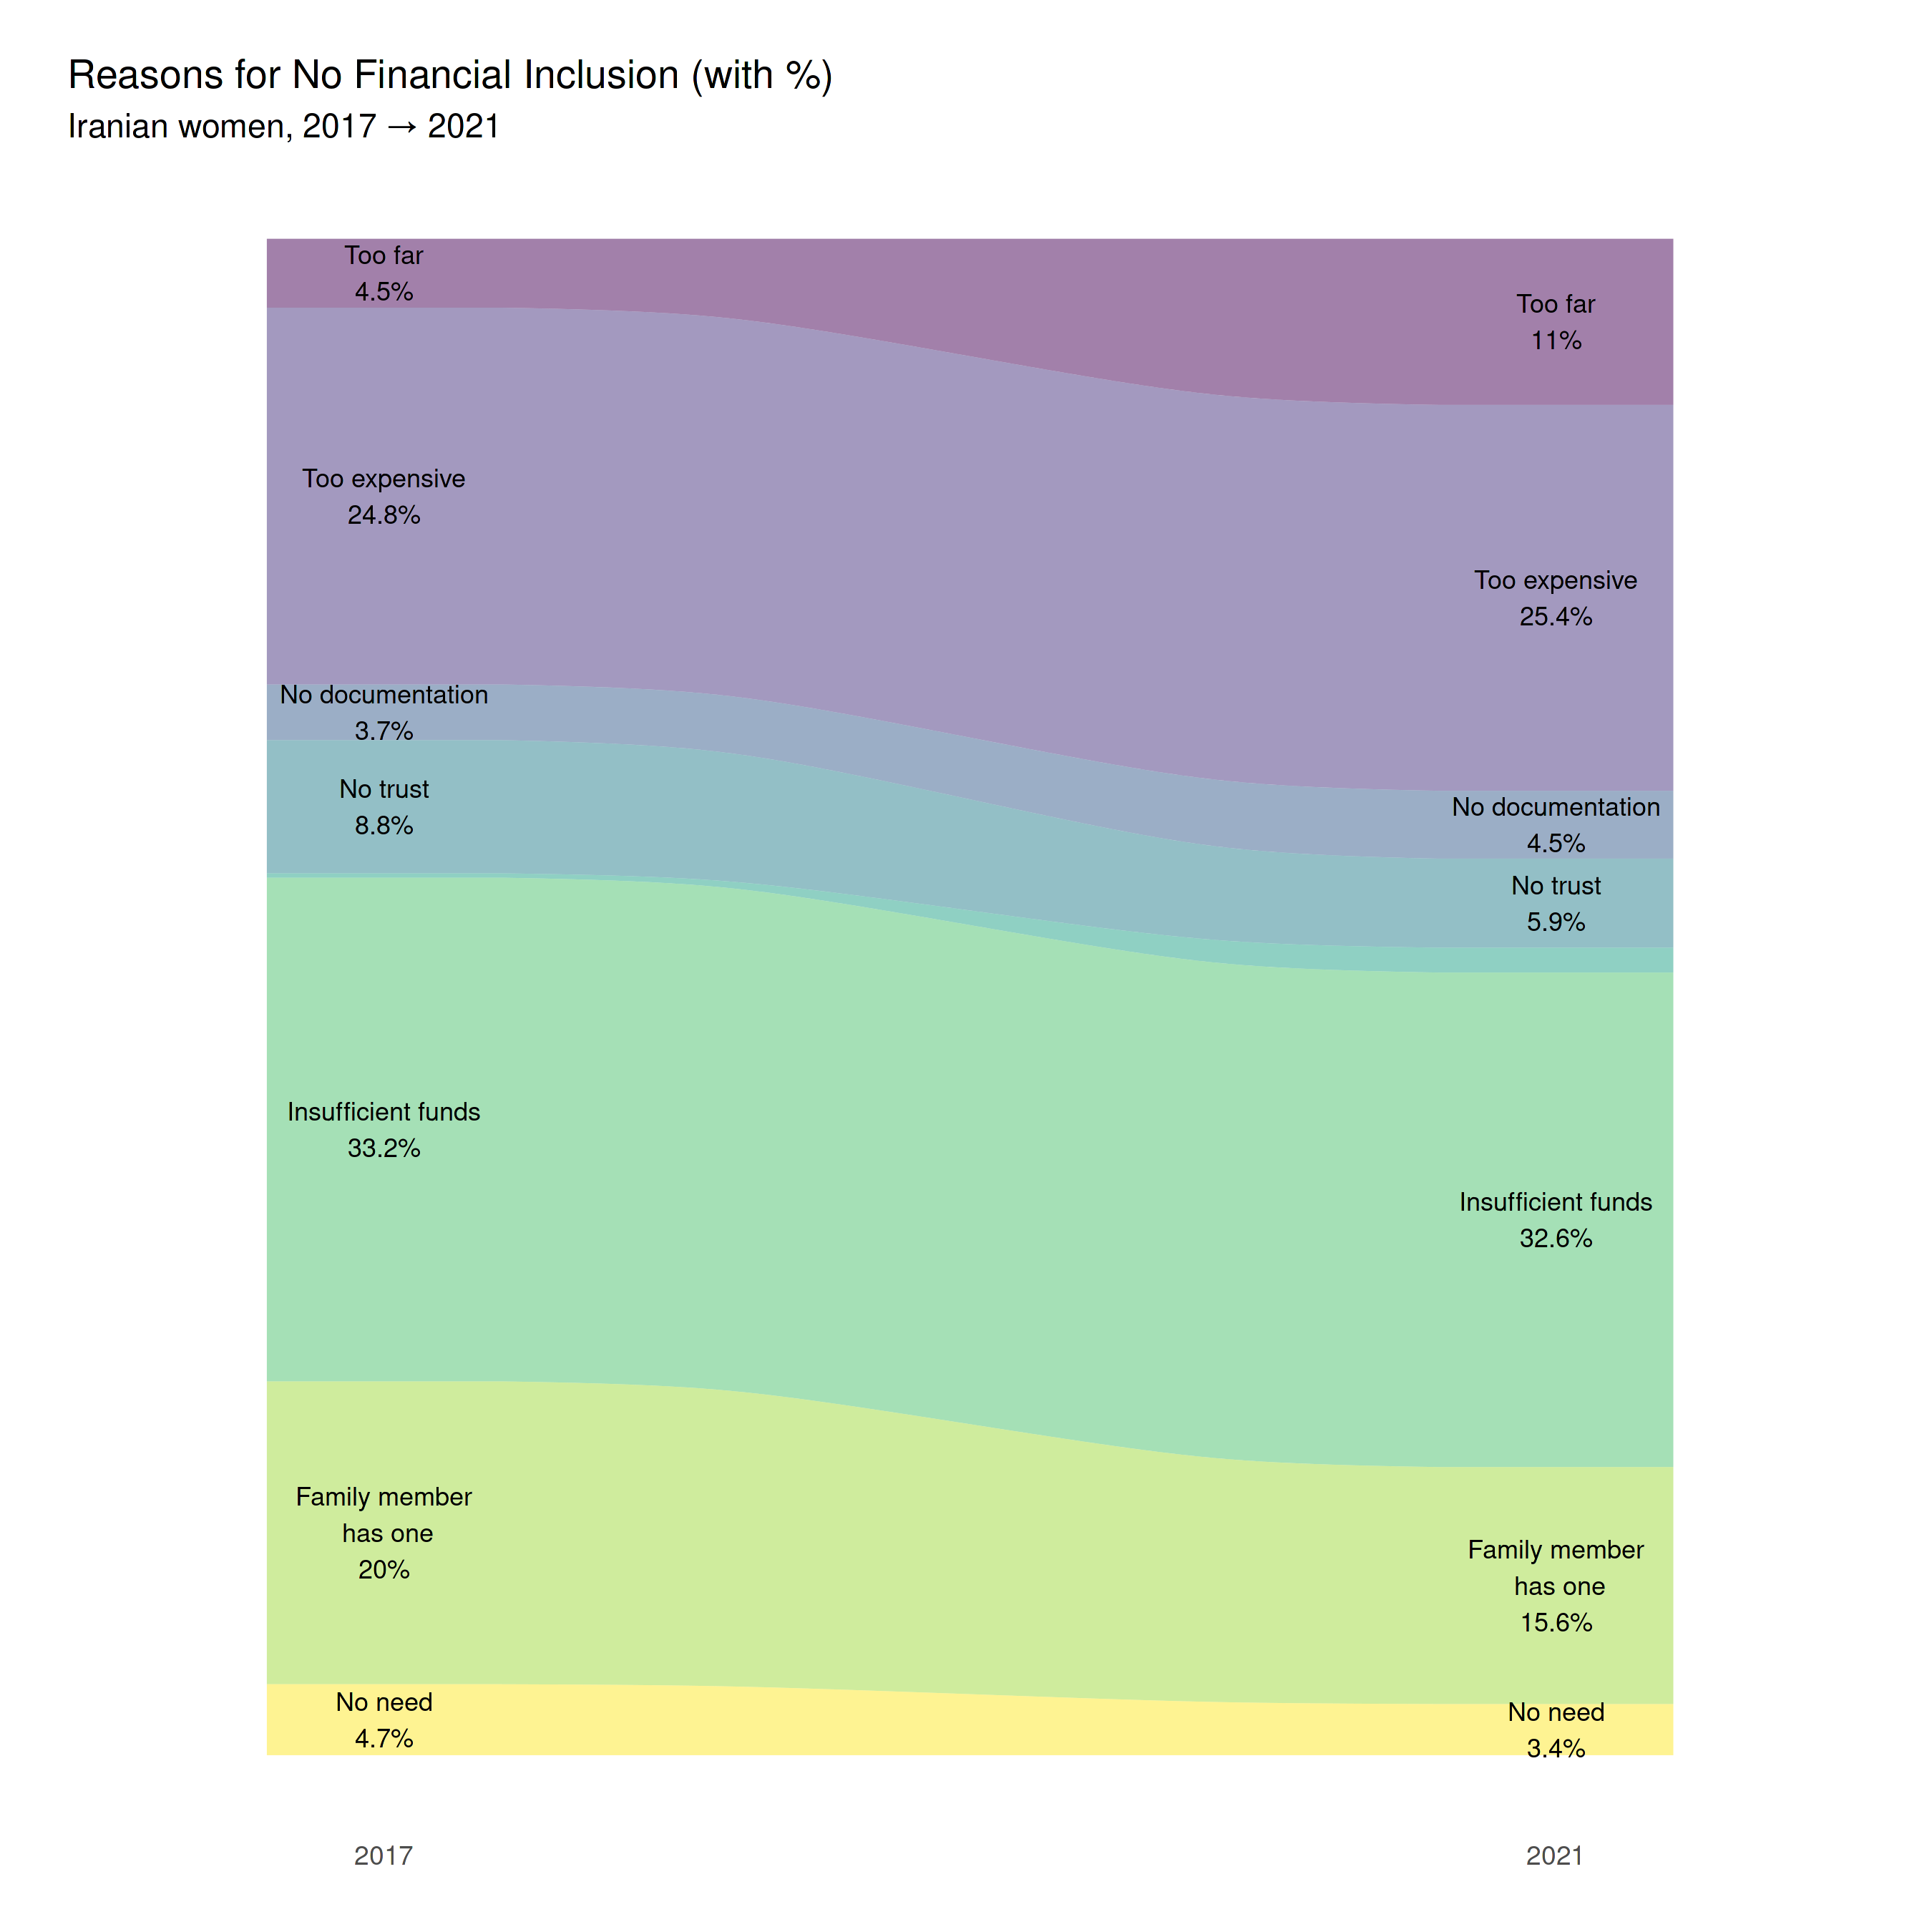

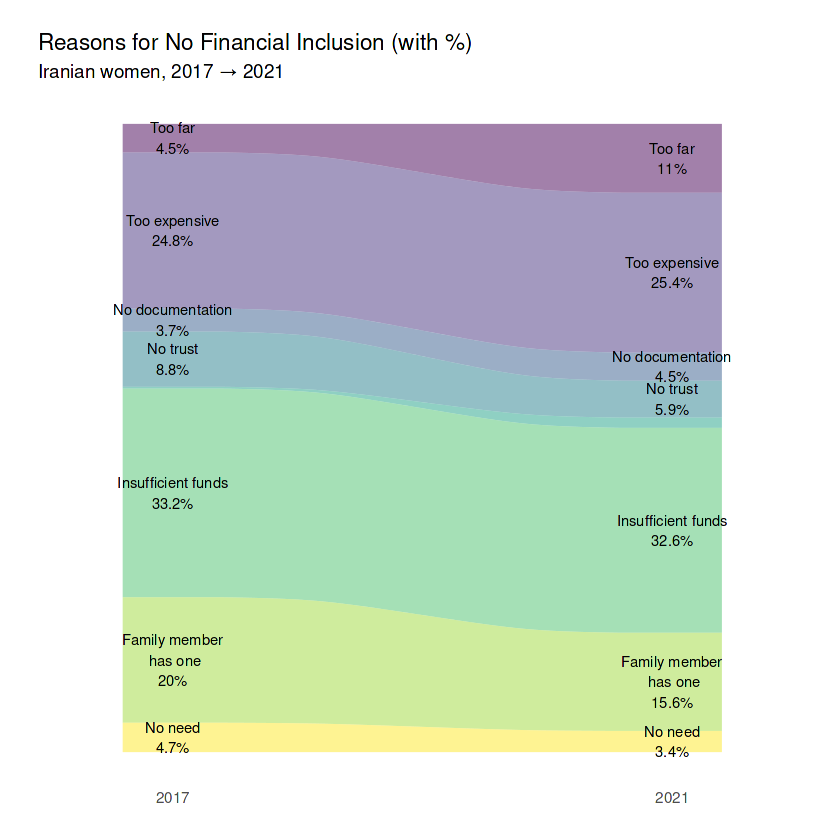

In [8]:
# prepare weighted shares
df <- gfi_tbl %>%
  filter(year_b %in% c(2017,2021),
         !is.na(reason_no_account_c)) %>%
  mutate(
    period = factor(year_b, levels = c(2017,2021)),
    reason = factor(reason_no_account_c,
                    levels = 0:7,
                    labels = c(
                      "Too far", "Too expensive", "No documentation",
                      "No trust", "Religious reasons",
                      "Insufficient funds", "Family member\n has one",
                      "No need"
                    ))
  ) %>%
  as_survey_design(weights = weight_d) %>%
  group_by(period, reason) %>%
  summarise(n = survey_total(vartype = NULL), .groups="drop") %>%
  group_by(period) %>%
  mutate(pct = n / sum(n)) %>%
  ungroup()

# plot with inline % labels, no legend, viridis palette
reason<-ggplot(df,
       aes(x        = as.numeric(period),
           alluvium = reason,
           y        = pct,
           fill     = reason)) +
  geom_alluvium(width = 0.2) +
  geom_text(stat = "alluvium",
            aes(label = paste0(reason, "\n", round(pct*100,1), "%")),
            size = 3, min.y = 0.02) +
  scale_x_continuous(breaks = c(1,2), labels = c("2017","2021")) +
  scale_fill_viridis_d(option = "D", guide = FALSE) +      # colorblind‐friendly & no legend
  labs(
    title    = "Reasons for No Financial Inclusion (with %)",
    subtitle = "Iranian women, 2017 → 2021",
    x = NULL, y = NULL
  ) +
coord_cartesian(xlim = c(0.8, 2.2))+
  theme_minimal() +
  theme(
    panel.grid    = element_blank(),
    axis.text.y   = element_blank(),
    axis.ticks    = element_blank(),
    legend.position = "none" ,
    plot.margin = margin(20,20,20,20)
  )
fig(reason,9,9,300,"reason")

Saved plot to: /kaggle/working/output/borrowing_odds_ratio.png



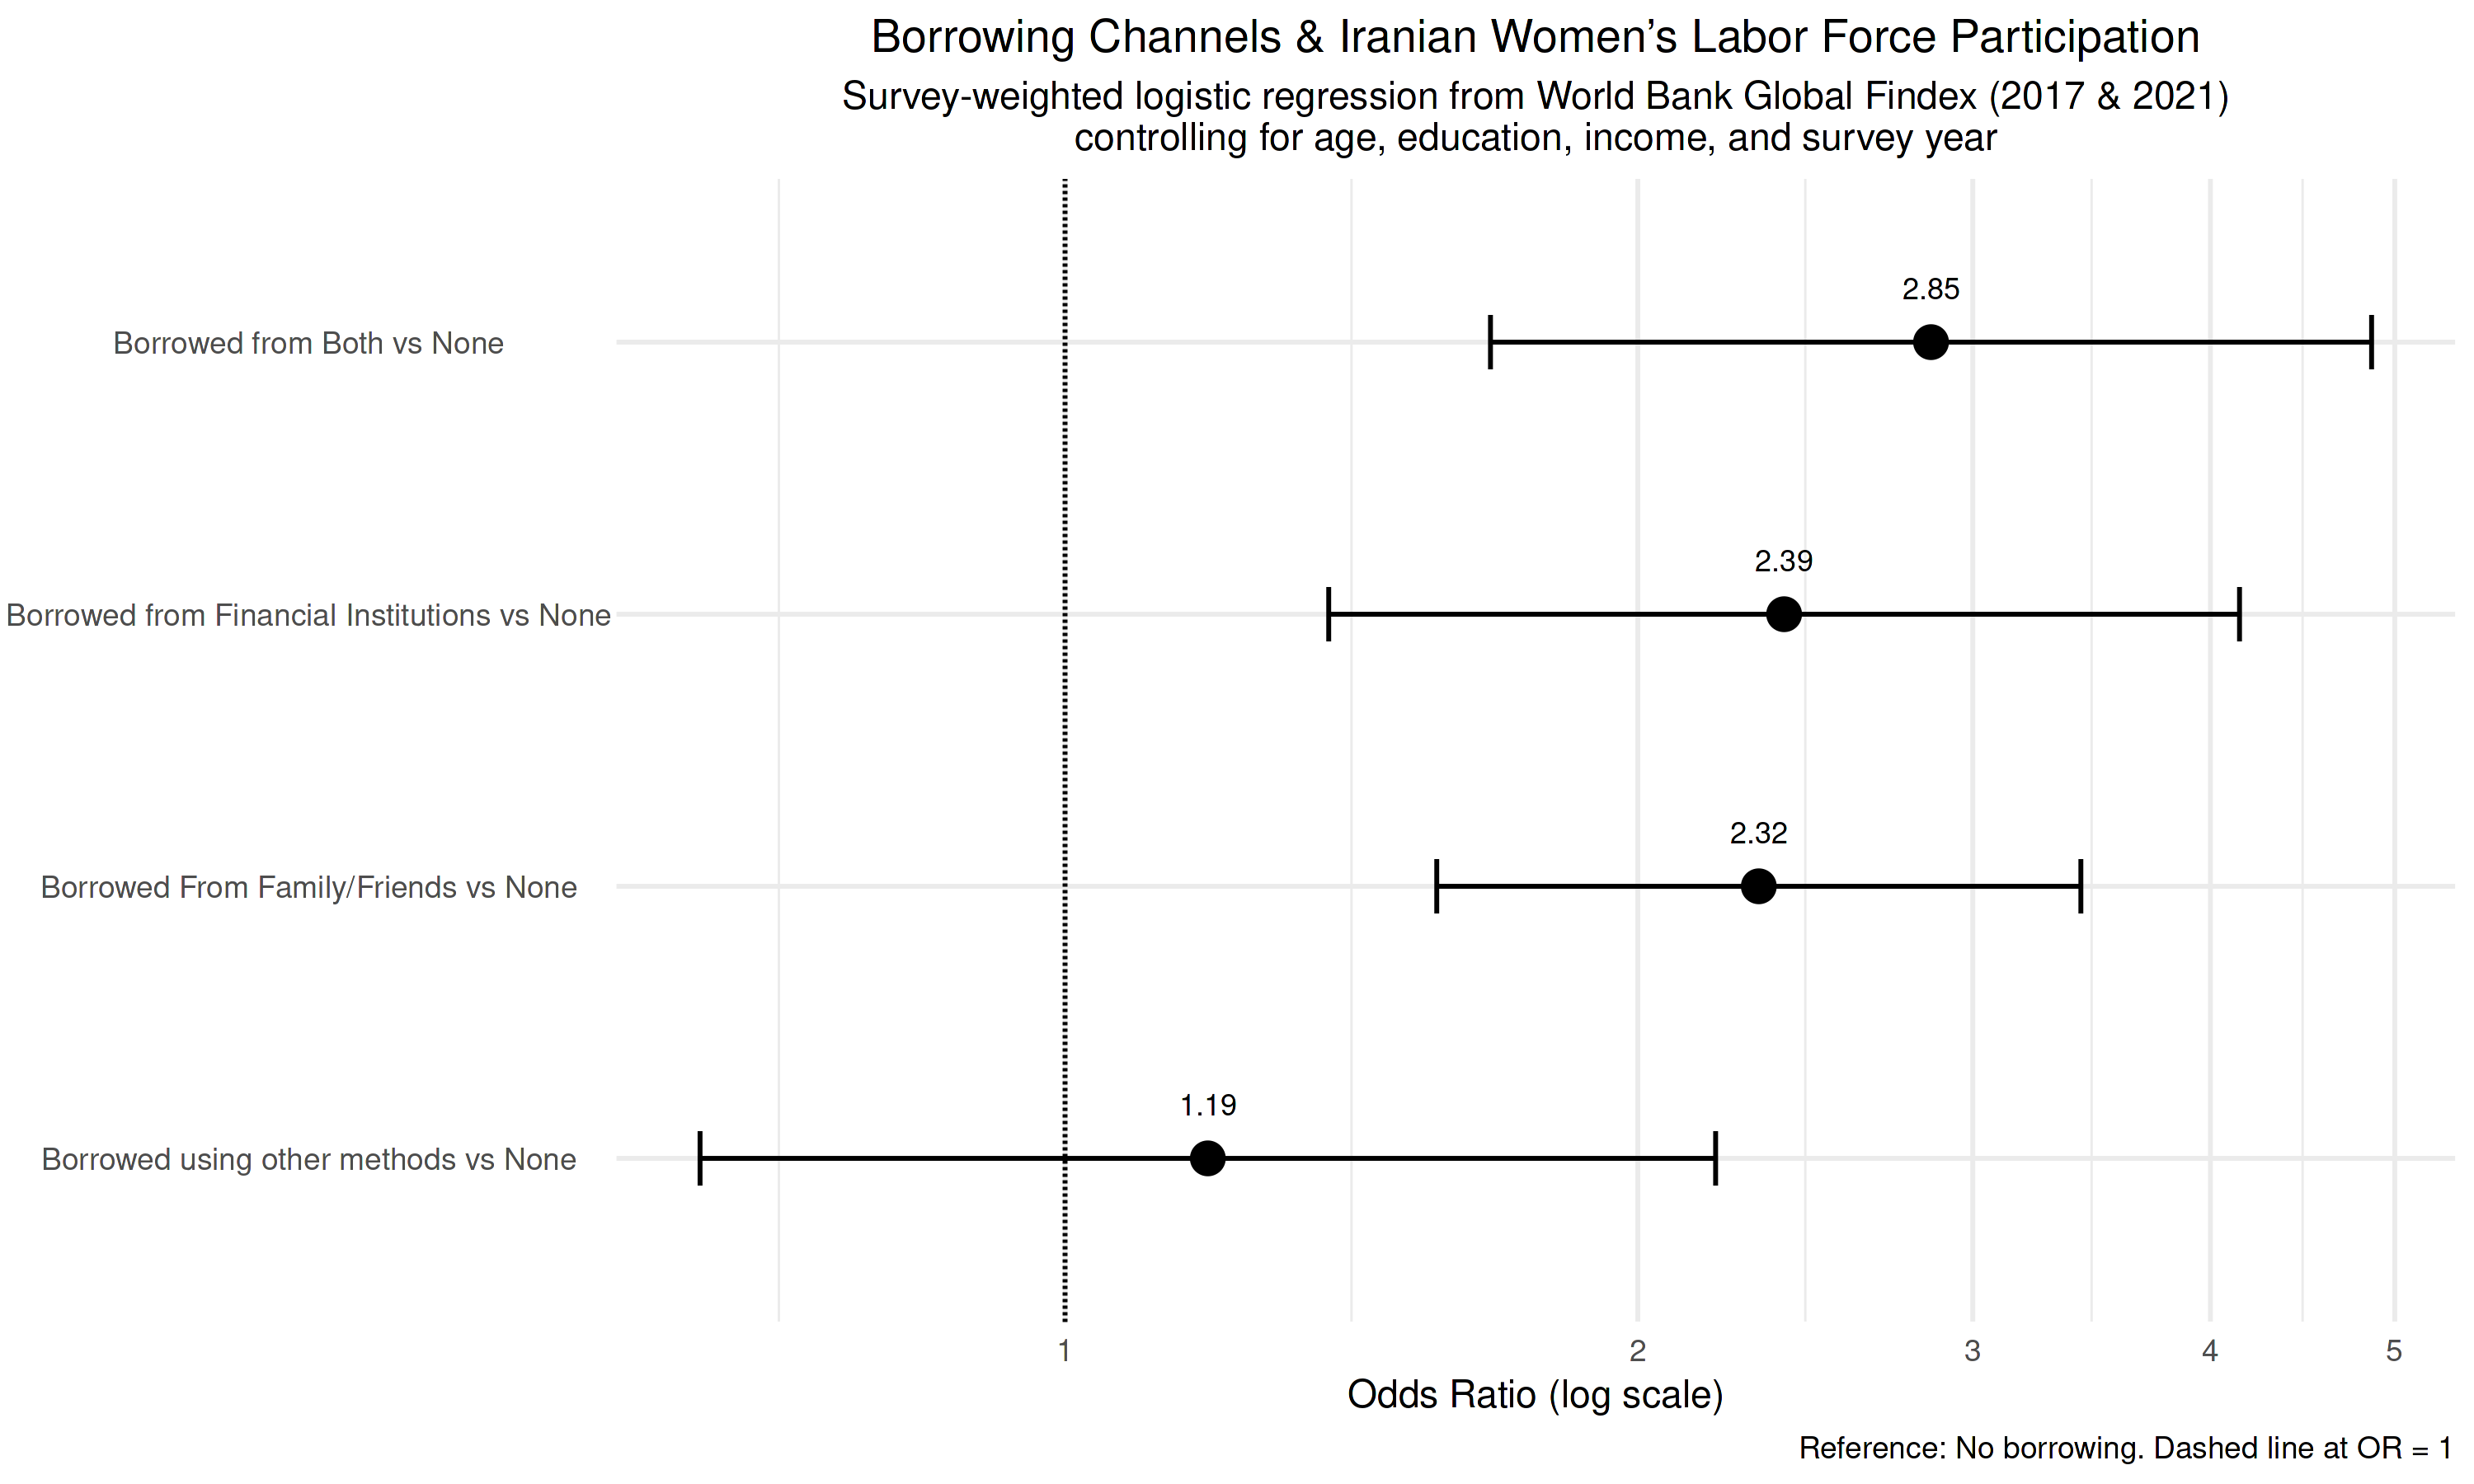

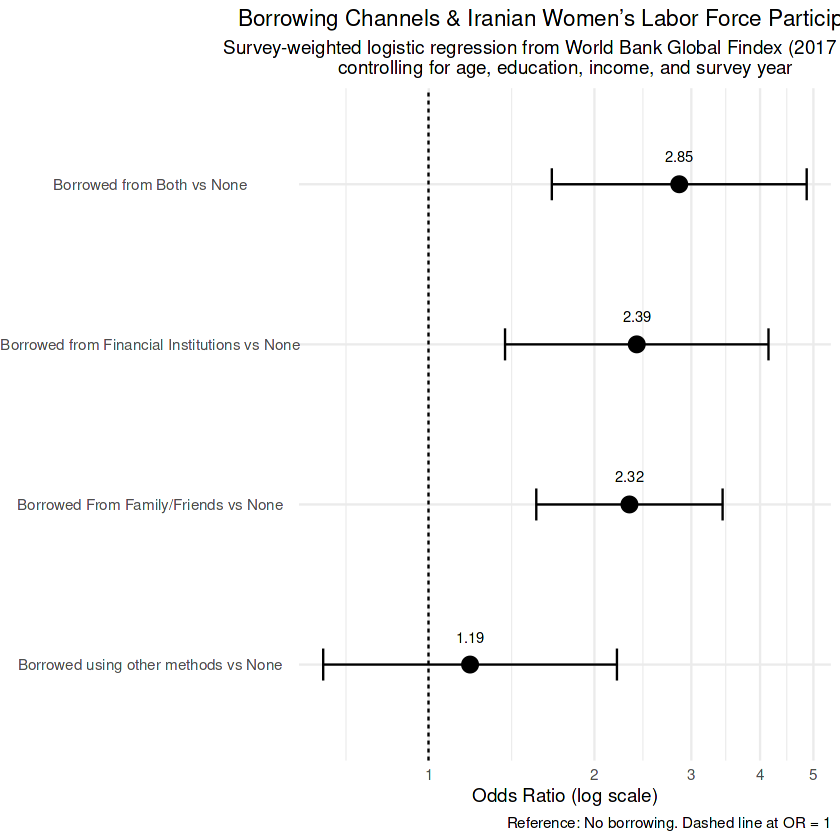

In [9]:
# 1. Build survey design (survey package)
svy <- svydesign(ids = ~1, weights = ~weight_d, data = gfi_tbl)

# 2. Fit weighted logistic regression (pooling years, with interaction if desired)
mod <- svyglm(in_the_workforce_b ~ factor(borrowed_in_the_past_year_c)
              + respondent_age_o
              + respondent_education_level_o
              + household_income_quintile_o
              + factor(year_b),
              design = svy, family = quasibinomial())


# 3. Tidy, exponentiate, and recode factor (put “other methods” first so it plots at the bottom)
or_tab <- broom::tidy(mod) |>
  filter(term %in% c(
    "factor(borrowed_in_the_past_year_c)1",
    "factor(borrowed_in_the_past_year_c)2",
    "factor(borrowed_in_the_past_year_c)3",
    "factor(borrowed_in_the_past_year_c)4"
  )) |>
  mutate(
    OR = exp(estimate),
    LCI = exp(estimate - 1.96 * std.error),
    UCI = exp(estimate + 1.96 * std.error),
    borrow_cat = factor(
      term,
      levels = c(
        "factor(borrowed_in_the_past_year_c)4",  # code 4 first → bottom
        "factor(borrowed_in_the_past_year_c)1",
        "factor(borrowed_in_the_past_year_c)2",
        "factor(borrowed_in_the_past_year_c)3"
      ),
      labels = c(
        "Borrowed using other methods vs None",
        "Borrowed From Family/Friends vs None",
        "Borrowed from Financial Institutions vs None",
        "Borrowed from Both vs None"
      )
    )
  )

borrow_odds_plot <- or_tab |>
  ggplot(aes(x = OR, y = borrow_cat)) +
    geom_point(size = 4) +
    # 1. put OR labels above each dot
    geom_text(aes(label = sprintf("%.2f", OR)),
              vjust = -2,               # nudge text above the point
              size  = 3) +
    geom_errorbarh(aes(xmin = LCI, xmax = UCI), height = 0.2) +
    geom_vline(xintercept = 1, linetype = "dashed") +
    # 2. include even-numbered grid breaks
    scale_x_log10(breaks = 1:5) +
    labs(
      title    = "Borrowing Channels & Iranian Women’s Labor Force Participation",
      subtitle = "Survey-weighted logistic regression from World Bank Global Findex (2017 & 2021)\ncontrolling for age, education, income, and survey year",
      x        = "Odds Ratio (log scale)",
      y        = NULL,
      caption  = "Reference: No borrowing. Dashed line at OR = 1"
    ) +
    theme_minimal() +
    theme(
      # 3. center title, subtitle, and y-axis category labels
      plot.title    = element_text(hjust = 0.5),
      plot.subtitle = element_text(hjust = 0.5),
      axis.text.y   = element_text(hjust = 0.5)
    )

fig(borrow_odds_plot,10,6,300,"borrowing_odds_ratio")

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).”


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_errorbarh()`).”


Saved plot to: /kaggle/working/output/pension_transfer_odds_ratio.png



Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).”


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_errorbarh()`).”


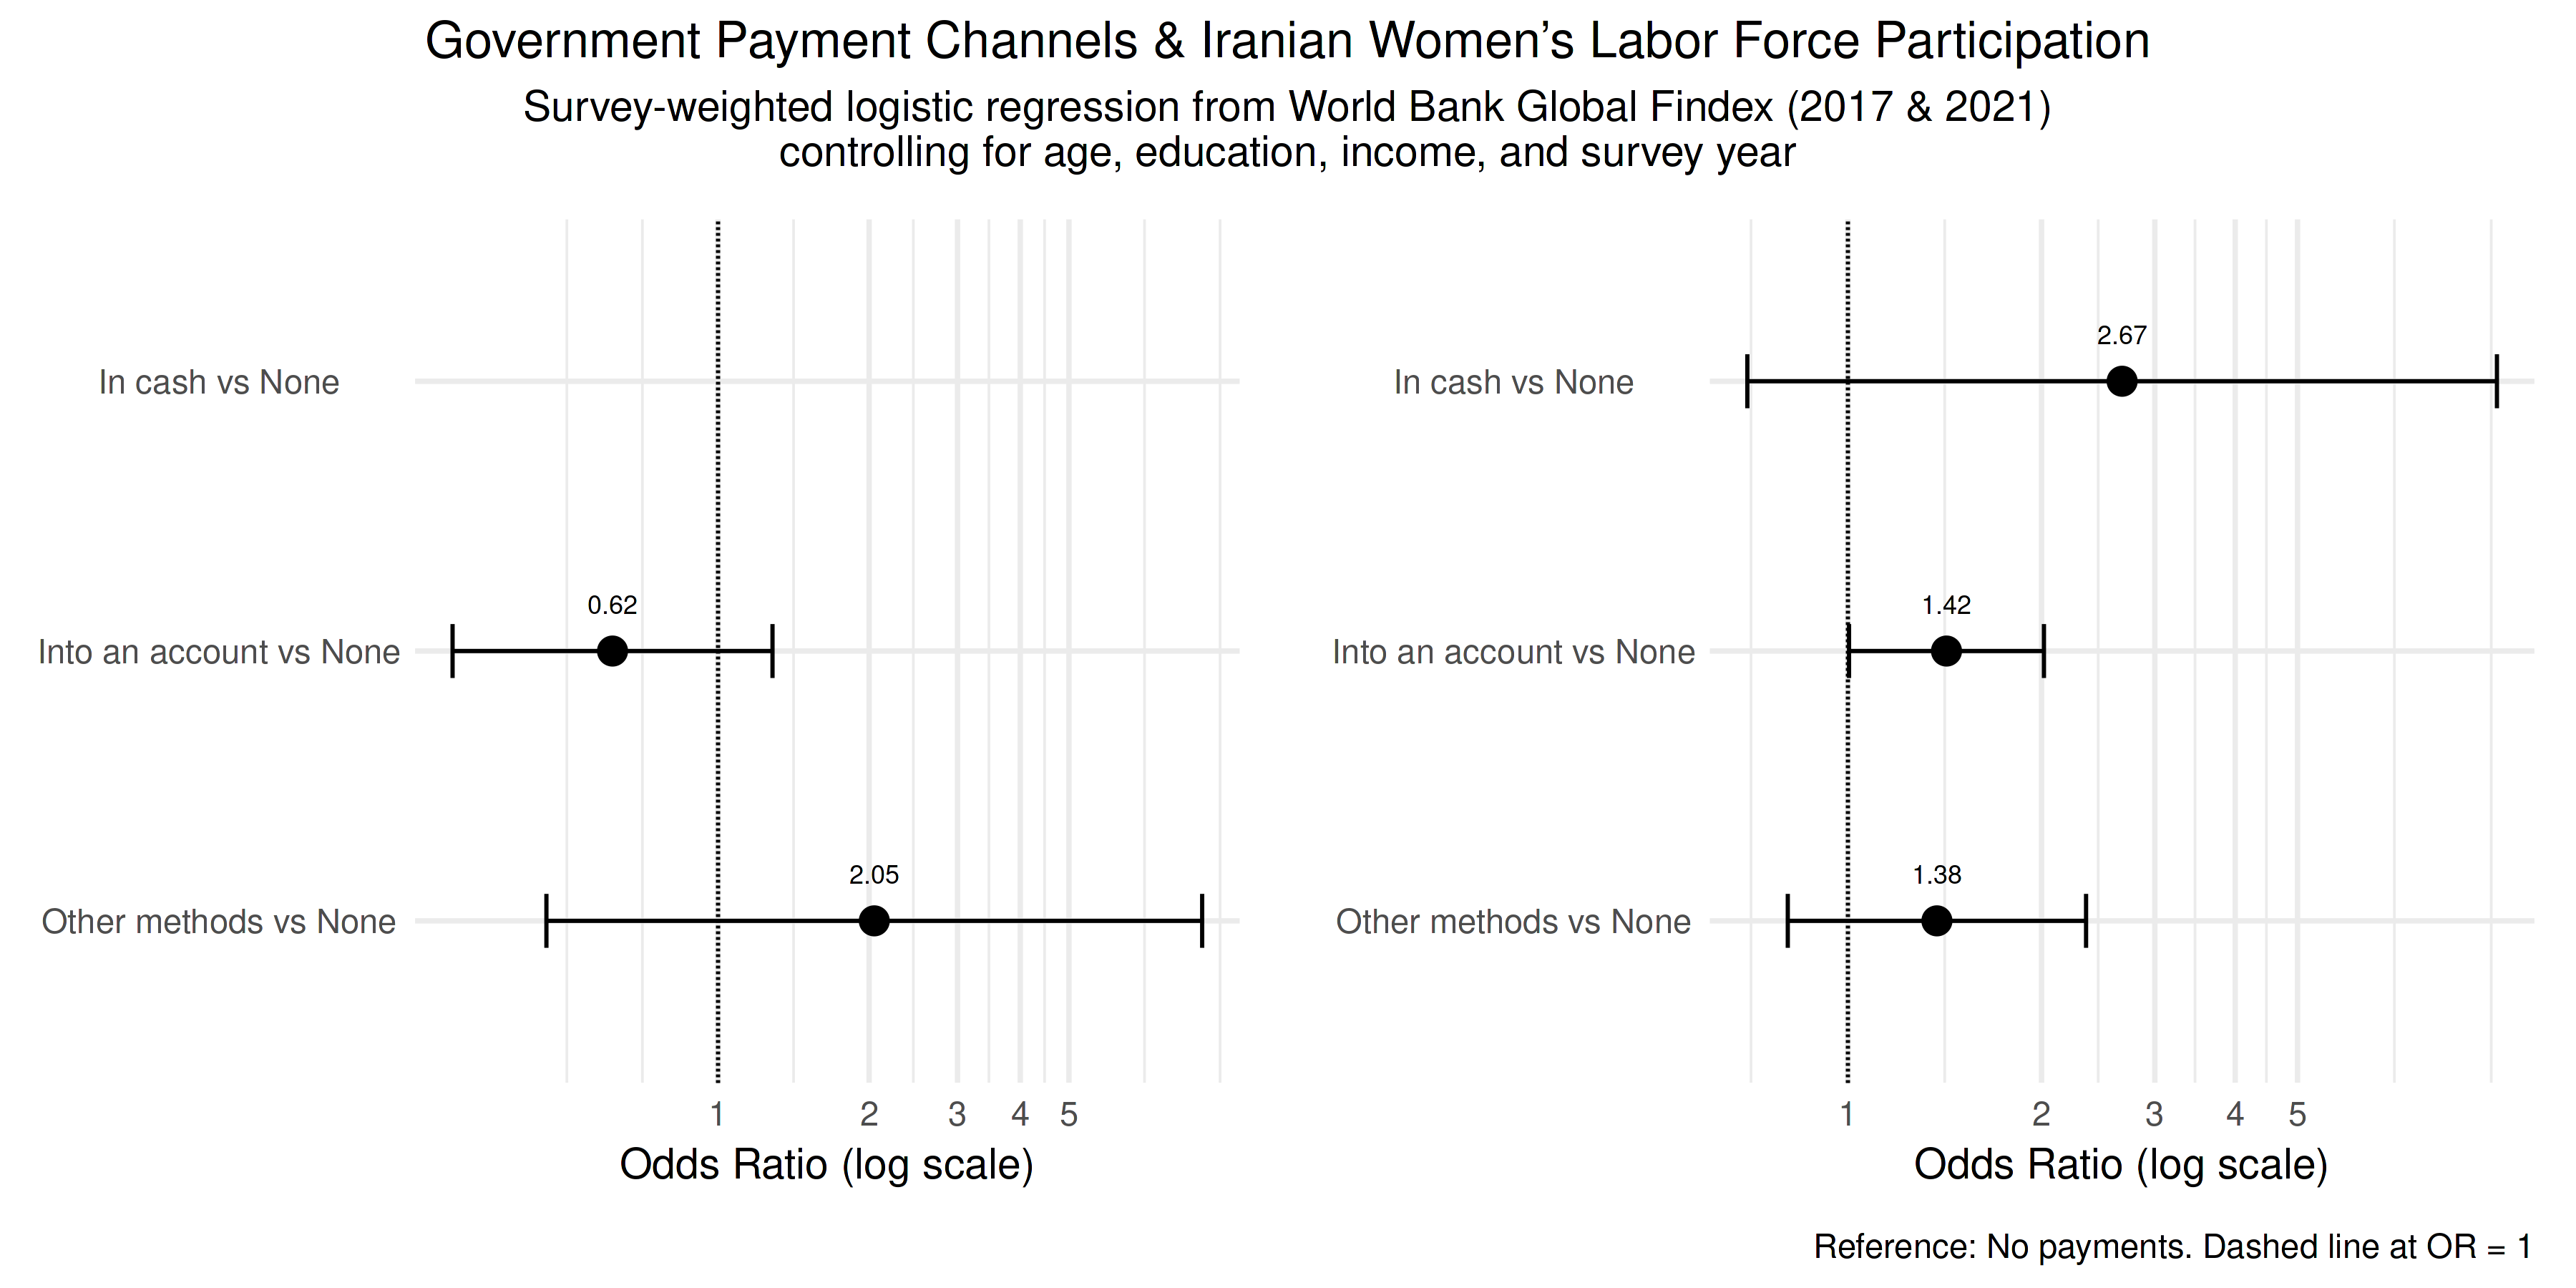

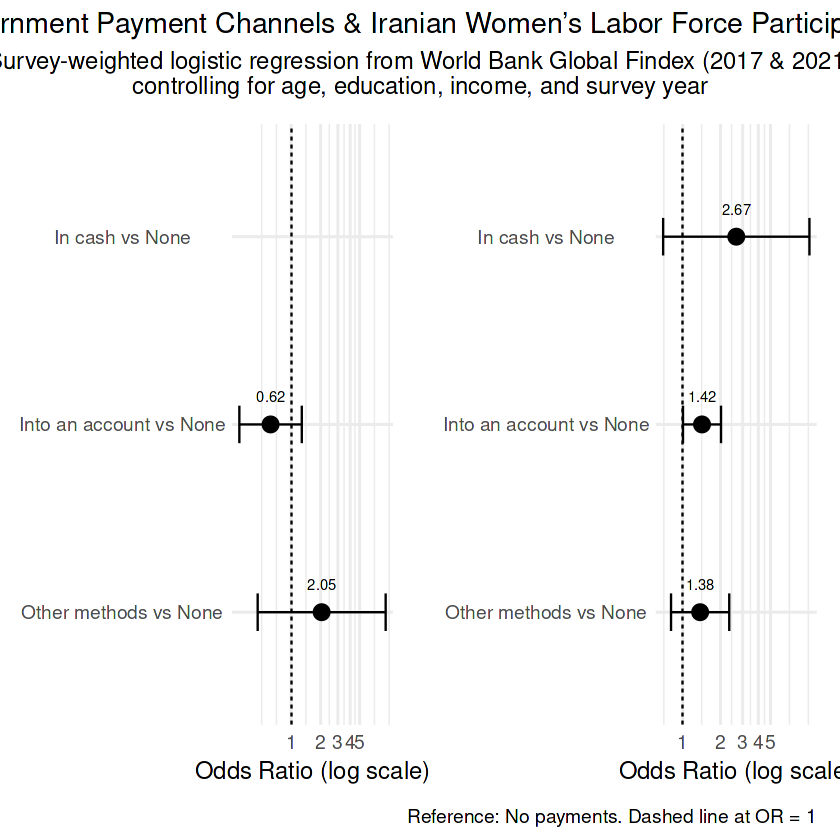

In [10]:
# 1. Survey design
svy <- svydesign(
  ids     = ~1,
  weights = ~weight_d,
  data    = gfi_tbl
)

# 2. Fit the survey‐weighted logistic model
mod <- svyglm(
  in_the_workforce_b ~
    factor(received_government_transfers_c) +
    factor(received_government_pension_payment_c) +
    respondent_age_o +
    respondent_education_level_o +
    household_income_quintile_o +
    factor(year_b),
  design = svy,
  family = quasibinomial()
)

# 3. Tidy & compute odds ratios + CIs + labels
or_tab <- broom::tidy(mod) |>
  filter(term %in% c(
    paste0("factor(received_government_transfers_c)",       1:3),
    paste0("factor(received_government_pension_payment_c)", 1:3)
  )) |>
  mutate(
    OR  = exp(estimate),
    LCI = exp(estimate - 1.96 * std.error),
    UCI = exp(estimate + 1.96 * std.error),
    variable = ifelse(
      grepl("transfers", term),
      "Government Transfers",
      "Government Pensions"
    ),
    payment_cat = factor(
      term,
      levels = c(
        # transfers
        "factor(received_government_transfers_c)3",
        "factor(received_government_transfers_c)1",
        "factor(received_government_transfers_c)2",
        # pensions
        "factor(received_government_pension_payment_c)3",
        "factor(received_government_pension_payment_c)1",
        "factor(received_government_pension_payment_c)2"
      ),
      labels = rep(
        c("Other methods vs None",
          "Into an account vs None",
          "In cash vs None"),
        2
      )
    )
  )

# 4. Helper to build each panel
make_panel <- function(df, show_y_axis) {
  df |>
    # drop the zero‐OR pension cash row
    filter(!(variable == "Government Pensions" & payment_cat == "In cash vs None")) |>
    # rebuild the full 3×2 grid, inserting NA for the missing slot
    tidyr::complete(
      variable,
      payment_cat = c(
        "Other methods vs None",
        "Into an account vs None",
        "In cash vs None"
      ),
      fill = list(OR = NA_real_, LCI = NA_real_, UCI = NA_real_)
    ) |>
    ggplot(aes(x = OR, y = payment_cat)) +
      geom_point(size = 4) +
      geom_text(aes(label = ifelse(is.na(OR), "", sprintf("%.2f", OR))),
                vjust = -2, size = 3) +
      geom_errorbarh(aes(xmin = LCI, xmax = UCI), height = 0.2) +
      geom_vline(xintercept = 1, linetype = "dashed") +
      scale_x_log10(breaks = 1:5) +
      scale_y_discrete(
        limits = c(
          "Other methods vs None",
          "Into an account vs None",
          "In cash vs None"
        )
      ) +
      labs(
        x = "Odds Ratio (log scale)",
        y = if (show_y_axis) NULL else ""
      ) +
      theme_minimal()    # <— no size tweaks here; we’ll do them globally
}

# 5. Make each half
p_pensions <- make_panel(
  filter(or_tab, variable == "Government Pensions"),
  show_y_axis = TRUE
)

p_transfers <- make_panel(
  filter(or_tab, variable == "Government Transfers"),
  show_y_axis = FALSE
)

# 6. Combine and annotate, then apply one global theme to both
final_plot <- p_pensions + p_transfers +
  plot_layout(nrow = 1, widths = c(1, 1)) +
  plot_annotation(
    title    = "Government Payment Channels & Iranian Women’s Labor Force Participation",
    subtitle = "Survey-weighted logistic regression from World Bank Global Findex (2017 & 2021)\ncontrolling for age, education, income, and survey year",
    caption  = "Reference: No payments. Dashed line at OR = 1"
  ) & 
  theme_minimal(base_size = 14) &                        # ← sets base font size equally
  theme(
    plot.title    = element_text(hjust = 0.5),
    plot.subtitle = element_text(hjust = 0.5),
    axis.text.y   = element_text(hjust = 0.5)
  )

fig(final_plot,12,6,300,"pension_transfer_odds_ratio")

Saved plot to: /kaggle/working/output/pension.png



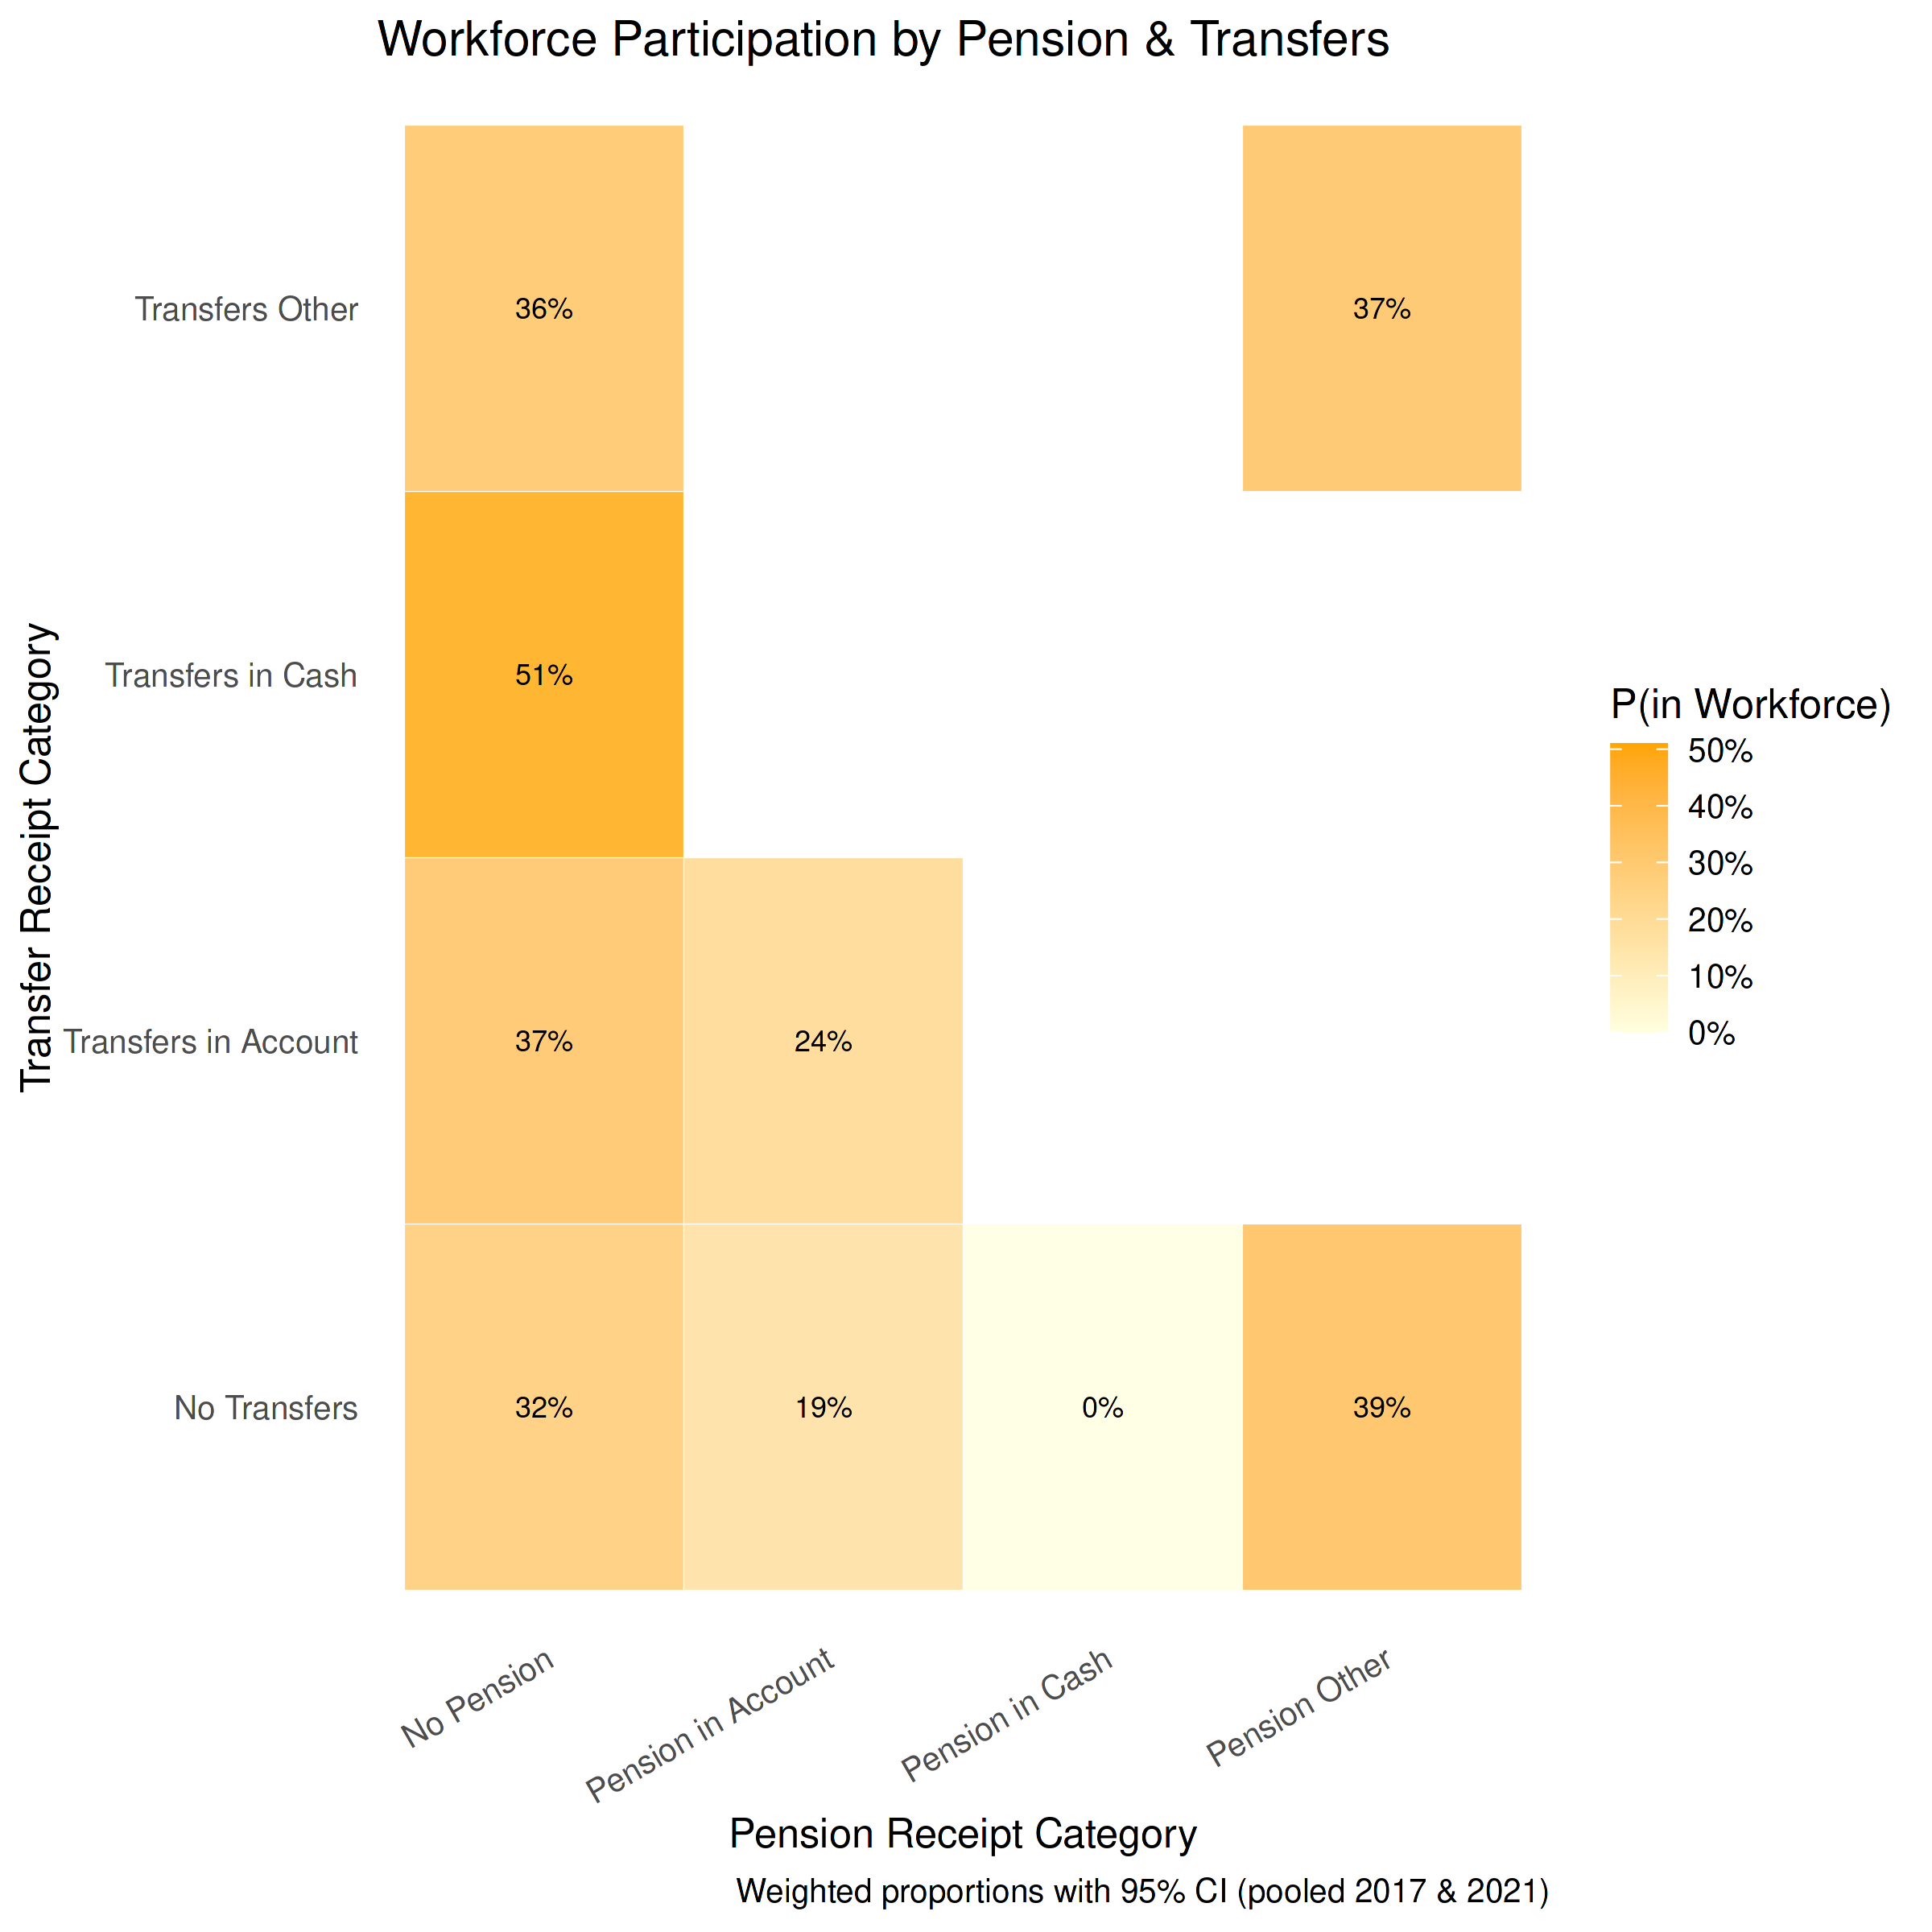

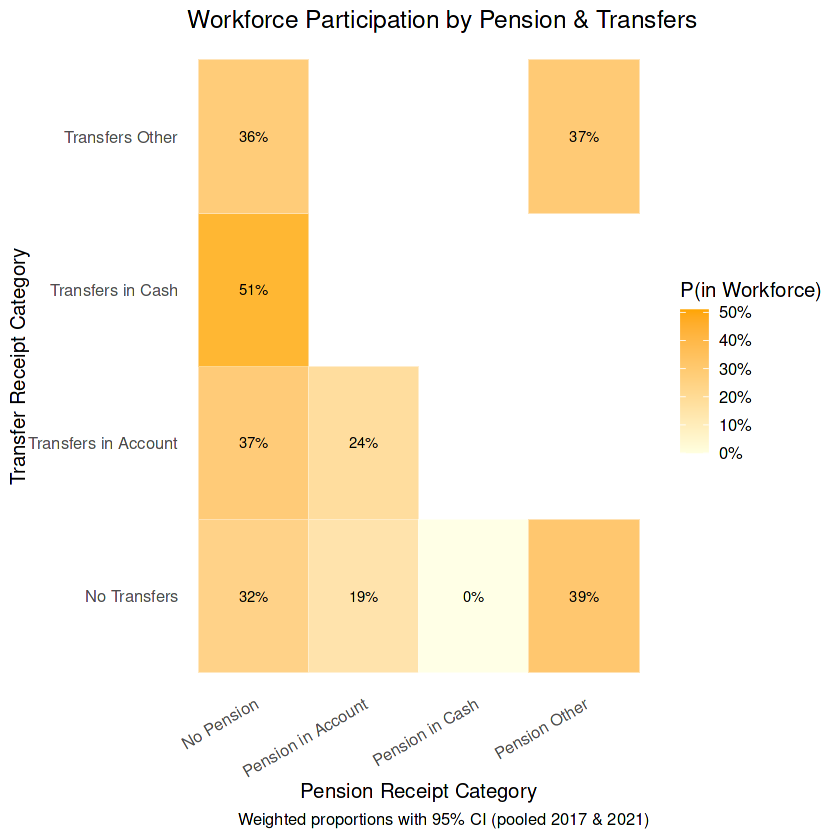

In [11]:
# ===============================
# Heatmap: Workforce Participation by Pension × Transfers
# ===============================

# 2. Define survey design
gfi_svy <- gfi_tbl |>
  as_survey_design(weights = weight_d)

# 3. Summarize workforce participation by Pension × Transfers
pension_transfer_df <- gfi_svy |>
  filter(
    !is.na(received_government_pension_payment_c),
    !is.na(received_government_transfers_c)
  ) |>
  group_by(
    received_government_pension_payment_c,
    received_government_transfers_c
  ) |>
  summarise(
    p_work = survey_mean(in_the_workforce_b, vartype = "ci"),
    .groups = "drop"
  ) |>
  mutate(
    pension = factor(
      received_government_pension_payment_c,
      levels = 0:3,
      labels = c("No Pension","Pension in Account","Pension in Cash","Pension Other")
    ),
    transfers = factor(
      received_government_transfers_c,
      levels = 0:3,
      labels = c("No Transfers","Transfers in Account","Transfers in Cash","Transfers Other")
    )
  )

# 4. Build and display the heatmap
heatmap1 <- ggplot(pension_transfer_df,
                   aes(x = pension, y = transfers, fill = p_work)) +
  geom_tile(color = "white", alpha = 0.8) +
  geom_text(aes(label = percent(p_work, accuracy = 1)),
            color = "black", size = 3) +
  scale_fill_gradient(
    name   = "P(in Workforce)",
    low    = "#FFFFE0",
    high   = "#FFA500",
    labels = percent_format(accuracy = 1)
  ) +
  labs(
    title   = "Workforce Participation by Pension & Transfers",
    x       = "Pension Receipt Category",
    y       = "Transfer Receipt Category",
    caption = "Weighted proportions with 95% CI (pooled 2017 & 2021)"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    axis.text.x = element_text(angle = 30, hjust = 1),
    panel.grid  = element_blank()
  )

# Print to the R plotting window:
fig(heatmap1,8,8,300,"pension")


Saved plot to: /kaggle/working/output/deposit_withdraw.png



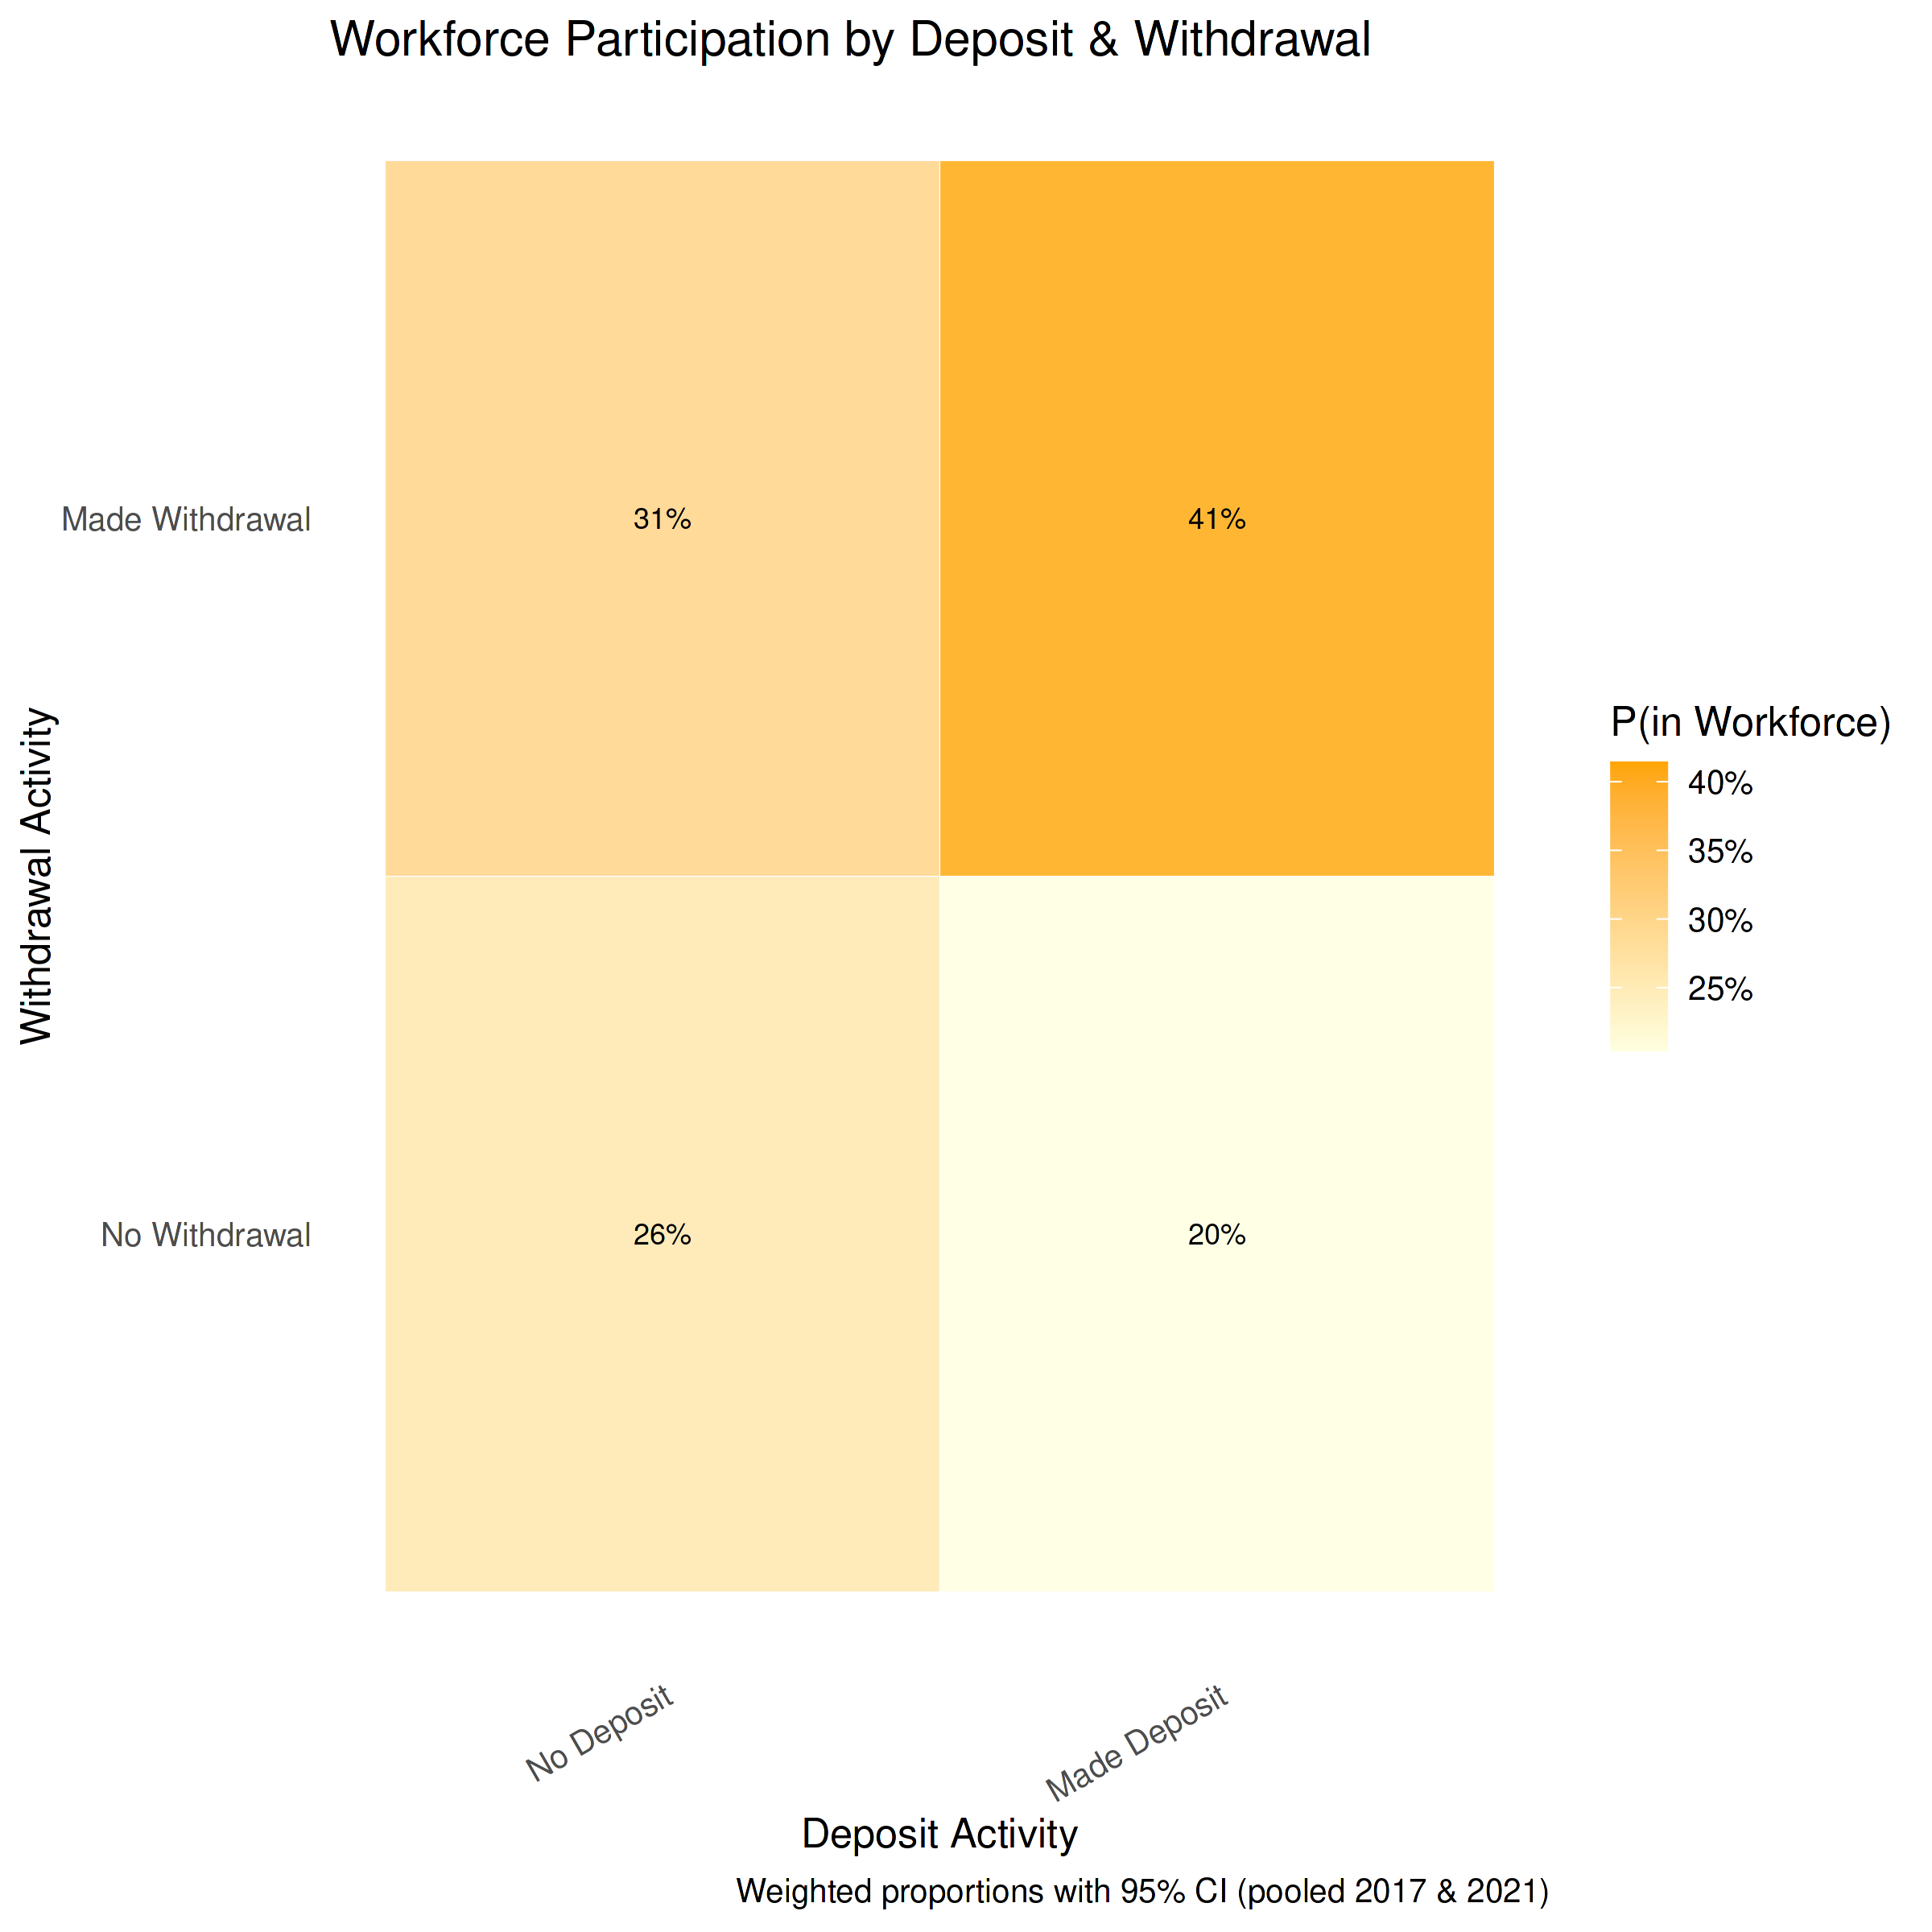

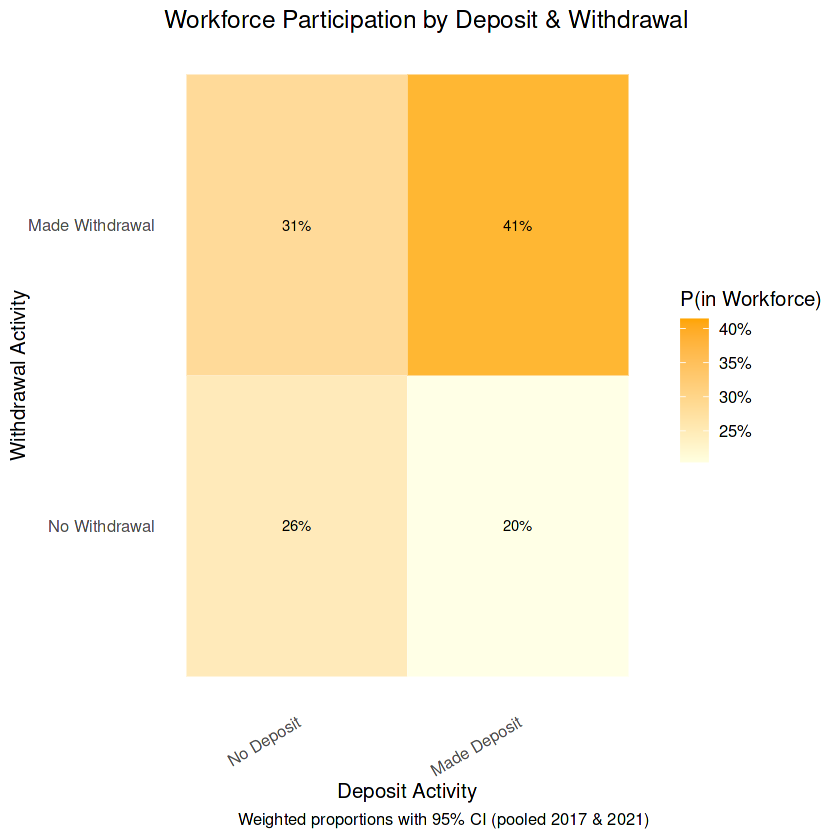

In [12]:
# ===============================
# Heatmap: Workforce Participation by Deposit × Withdrawal
# ===============================

gfi_svy <- gfi_tbl |>
  as_survey_design(weights = weight_d)

# 3. Summarize workforce participation by Deposit × Withdrawal
deposit_withdraw_df <- gfi_svy |>
  filter(
    !is.na(any_deposit_into_account_b),
    !is.na(any_withdrawal_from_account_b)
  ) |>
  group_by(
    any_deposit_into_account_b,
    any_withdrawal_from_account_b
  ) |>
  summarise(
    p_work = survey_mean(in_the_workforce_b, vartype = "ci"),
    .groups = "drop"
  ) |>
  mutate(
    deposit = factor(
      any_deposit_into_account_b,
      levels = c(0,1),
      labels = c("No Deposit","Made Deposit")
    ),
    withdrawal = factor(
      any_withdrawal_from_account_b,
      levels = c(0,1),
      labels = c("No Withdrawal","Made Withdrawal")
    )
  )

# 4. Build and display the heatmap
heatmap2 <- ggplot(deposit_withdraw_df,
                   aes(x = deposit, y = withdrawal, fill = p_work)) +
  geom_tile(color = "white", alpha = 0.8) +
  geom_text(aes(label = percent(p_work, accuracy = 1)),
            color = "black", size = 3) +
  scale_fill_gradient(
    name   = "P(in Workforce)",
    low    = "#FFFFE0",
    high   = "#FFA500",
    labels = percent_format(accuracy = 1)
  ) +
  labs(
    title   = "Workforce Participation by Deposit & Withdrawal",
    x       = "Deposit Activity",
    y       = "Withdrawal Activity",
    caption = "Weighted proportions with 95% CI (pooled 2017 & 2021)"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    axis.text.x = element_text(angle = 30, hjust = 1),
    panel.grid  = element_blank()
  )

# Print to the R plotting window:
fig(heatmap2,8,8,300,"deposit_withdraw")